In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings("ignore")
# Import own libraries 
import os, sys
script_path = os.path.realpath(os.path.dirname("10_on_trajectories"))
os.chdir(script_path)
sys.path.append("..")

from myLibraries.queries import * 
from myLibraries.events import *
from myLibraries.theoretical_functions import *
from myLibraries.utils import *

In [2]:
NUM_EVENTS = 500
P = 0.5
GAMMA = 0

#### Barabasi-Albert
- P=0.5, gamma=0, 100 Networks and 500 events
- fit function: (alpha * ln(t/t_v) +1)^beta

=> we want 
- alpha=(1-gamma)(2-p)/u 
- beta=1/(1-gamma)

In [3]:
# Theoretichal vertex trajectory for stretched exponential distribution
def theoretical_func(x, a, b, start_x):
    return  pow((a*(np.log(x/start_x)) + 1), b)

# Method to fit the theoretical trajectory to the given average trajectory 
def fit_trajectory(xdata, ydata):
    
    popt, pcov = curve_fit(lambda x, a, b: theoretical_func(x, a, b, xdata[0]), xdata, ydata, maxfev=5000, bounds=([0, 1], [np.inf, np.inf]))
    alpha = popt[0]
    beta = popt[1]

    return alpha, beta 


In [4]:
# df
df = pd.read_csv("Chung-Li_p05_g0.csv")
df

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,start_event
0,0,1,2,3,3,3,3,4,5,5,...,13,13,13,13,13,13,13,13,14,1
1,0,1,1,1,2,2,2,2,2,2,...,17,17,17,17,17,17,17,17,17,1
2,0,0,1,1,1,1,1,1,1,1,...,15,15,15,15,15,15,15,15,15,2
3,0,0,0,1,1,2,2,2,2,3,...,17,17,17,17,17,17,17,17,17,3
4,0,0,0,0,1,1,2,2,2,2,...,13,13,13,13,13,13,13,13,13,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25132,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,492
25133,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,1,1,494
25134,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,1,1,495
25135,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,497


In [5]:
# retrieve average trajectories by starting year
avg_x = []
avg_y = []
for curr_e in range(2, NUM_EVENTS):
    sub_df = df[df["start_event"]==curr_e]
    
    x, y = [],[]
    for e in range(curr_e, NUM_EVENTS):
        if(len(sub_df)!=0):
            x.append(e)
            y.append(sub_df[str(e)].mean())
        else:
            x.append(e)
            y.append(0)
    
    avg_x.append(x)
    avg_y.append(y)

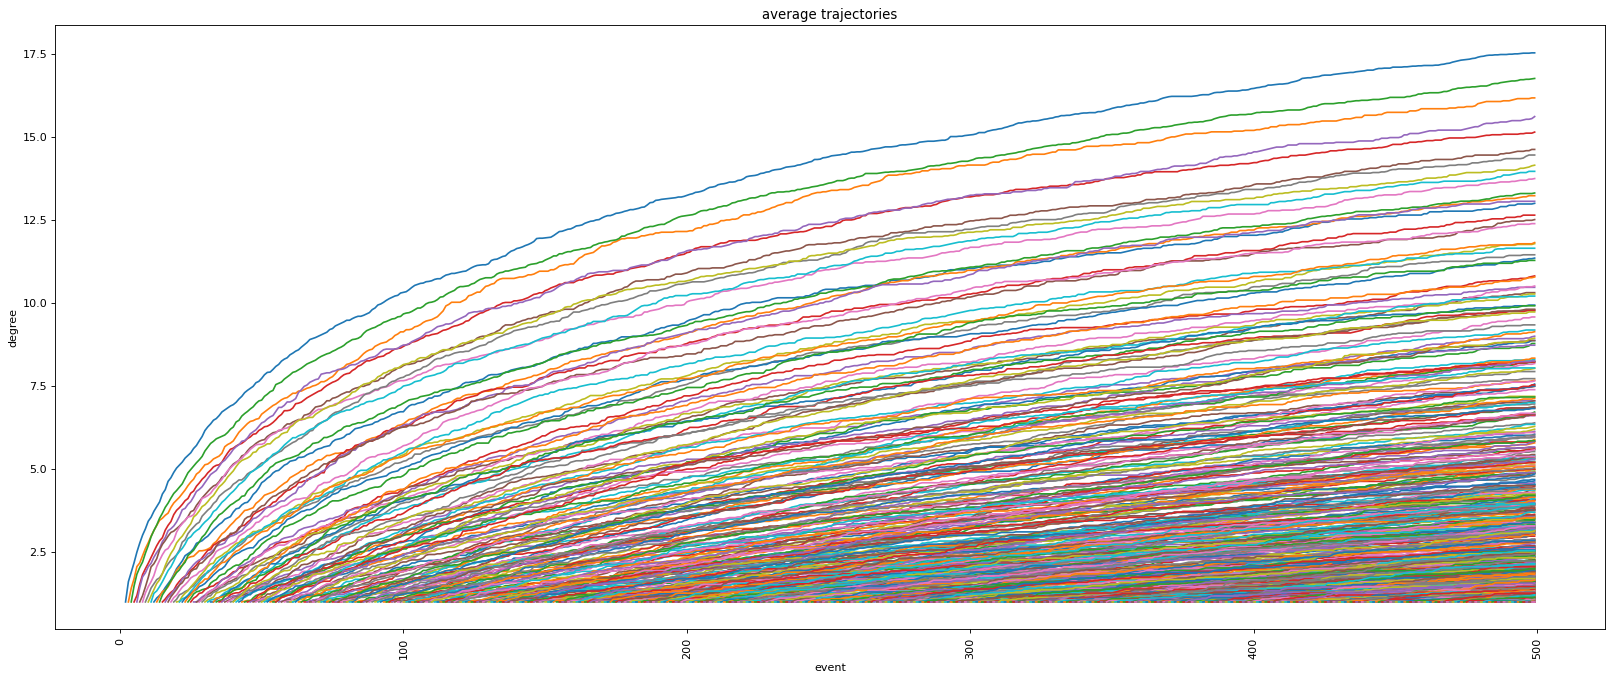

In [6]:
draw_multi_x("average trajectories", "event", "degree", avg_x, avg_y, [], 25, 10)

In [7]:
# get u 
def get_u(df):        
    sum_deg = 0
    for i in avg_y:
        sum_deg += pow(i[-1], GAMMA)
    
    return sum_deg/NUM_EVENTS

u = get_u(df)
expected_alpha = ((1-GAMMA)*(2-P))/u
expected_beta =  1/(1-GAMMA)
print("u = ", u)

u =  0.996


In [8]:
# retrive alphas and betas 

alphas = []
betas = []
diffs_alpha= []
diffs_beta= []

#print("-- event -- \t-- alpha -- \t -- alpha-1/2 --")
for curr_e in range(len(avg_x)):
    x = avg_x[curr_e]
    y = avg_y[curr_e]
    
    alpha, beta = fit_trajectory(x, y)

        
    diff_alpha = "%.4f" % pow(float(alpha) - expected_alpha, 2)
    diff_beta = "%.4f" % pow(float(beta) - expected_beta, 2)
        
    alpha = "%.4f" % alpha
    beta = "%.4f" % beta
    
    alphas.append(float(alpha))
    betas.append(float(beta))

    diffs_alpha.append(float(diff_alpha))
    diffs_beta.append(float(diff_beta))
    #print(curr_e, "\t\t", alpha, "\t\t", diff )



results = pd.DataFrame({"event": range(2, NUM_EVENTS), "alpha": alphas, "beta": betas, "diff_alpha": diffs_alpha, "diff_beta": diffs_beta})
results

,event,alpha,beta,diff_alpha,diff_beta
0,2,0.4383,2.3363,1.1400,1.785700e+00
1,3,0.4743,2.2753,1.0644,1.626400e+00
2,4,0.8055,1.7767,0.4908,6.032000e-01
3,5,0.8443,1.7199,0.4379,5.183000e-01
4,6,1.0265,1.6005,0.2299,3.607000e-01
...,...,...,...,...,...
493,495,0.0071,1.0071,2.2467,1.000000e-04
494,496,0.0019,1064.6799,2.2624,1.131415e+06
495,497,0.0034,1150.7501,2.2578,1.321925e+06
496,498,0.0279,1.0279,2.1849,8.000000e-04


In [10]:
results.sort_values(by="beta",  ascending=False)

,event,alpha,beta,diff_alpha,diff_beta
447,449,0.0002,13142.2547,2.2675,1.726926e+08
411,413,0.0002,13027.5996,2.2675,1.696923e+08
441,443,0.0002,12579.1207,2.2675,1.582091e+08
428,430,0.0002,12210.2408,2.2676,1.490656e+08
421,423,0.0002,11608.2311,2.2676,1.347278e+08
...,...,...,...,...,...
433,435,3.0271,1.0000,2.3136,0.000000e+00
366,368,2.1980,1.0000,0.4789,0.000000e+00
431,433,1.5455,1.0000,0.0016,0.000000e+00
430,432,1.7373,1.0000,0.0535,0.000000e+00


a: 0.0001968621096272936 , b: 13142.254747445564


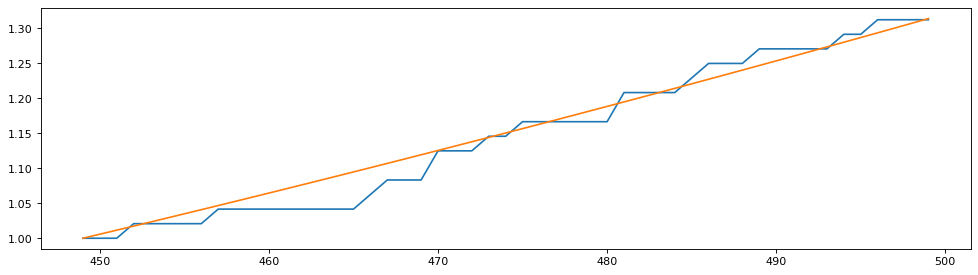

In [14]:
# print one function with his fitting for the  given event 
curr_e = 447
x = avg_x[curr_e]
y = avg_y[curr_e]

alpha, beta = fit_trajectory(x, y)
print("a:", alpha, ", b:", beta)
fit_y = theoretical_func(x, alpha, beta, np.int64(x[0]))

plt.figure(figsize=(15, 4), dpi=80)
plt.plot(x,y)
plt.plot(x,fit_y)
plt.show()

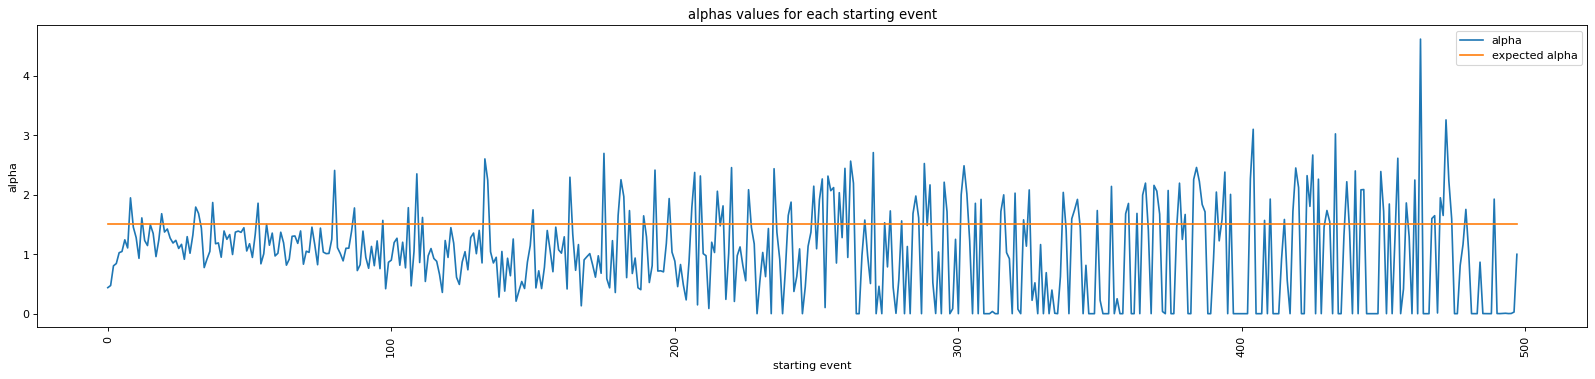

In [18]:
# plot alpha
draw("alphas values for each starting event", 
     "starting event", 
     "alpha", 
     [i for i in range(len(results))], 
     [results["alpha"],  [expected_alpha for i in range(len(results))]], 
     ["alpha", "expected alpha"],
     25, 5)

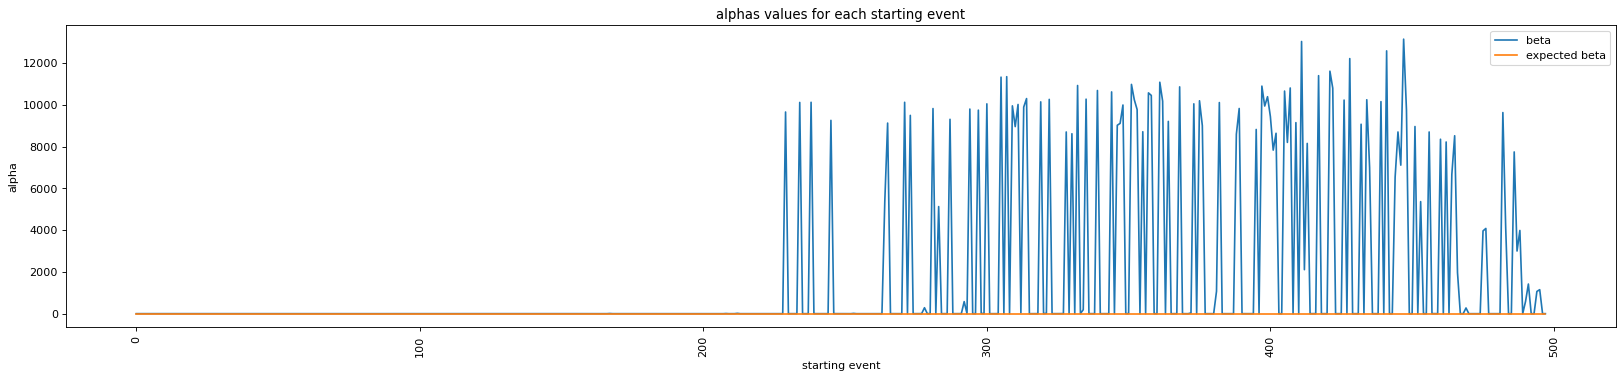

In [20]:
# plot beta
draw("beta values for each starting event", 
     "starting event", 
     "beta", 
     [i for i in range(len(results))], 
     [results["beta"],  [expected_beta for i in range(len(results))]],
     ["beta", "expected beta"], 25, 5)

In [21]:
# data infos
print(" -- alpha must be", "%.4f" % expected_alpha, "--")
print(" -- beta must be", "%.4f" % expected_beta, "--\n")

# how many alpha differ from the  expectation of the given tolerance
print("-- #alphas such that alpha-((1-u)*(2-P))/u < tolerance -- ")
tolerance = 0.0
while tolerance <= 2:
    print("tolerance =", "%.1f"%tolerance, "-> #aphas =", len(results[pow(results["diff_alpha"],1/2) <= tolerance]))
    tolerance += 0.1
    
print()

print("-- #betas such that beta-((1-GAMMA) < tolerance -- ")
tolerance = 0.0
while tolerance <= 2:
    print("tolerance <=", "%.1f"%tolerance, "-> #betas =", len(results[pow(results["diff_beta"],1/2) <= tolerance]))
    tolerance += 0.1

 -- alpha must be 1.5060 --
 -- beta must be 1.0000 --

-- #alphas such that alpha-((1-u)*(2-P))/u < tolerance -- 
tolerance = 0.0 -> #aphas = 1
tolerance = 0.1 -> #aphas = 31
tolerance = 0.2 -> #aphas = 69
tolerance = 0.3 -> #aphas = 110
tolerance = 0.4 -> #aphas = 147
tolerance = 0.5 -> #aphas = 196
tolerance = 0.6 -> #aphas = 239
tolerance = 0.7 -> #aphas = 275
tolerance = 0.8 -> #aphas = 302
tolerance = 0.9 -> #aphas = 322
tolerance = 1.0 -> #aphas = 341
tolerance = 1.1 -> #aphas = 360
tolerance = 1.2 -> #aphas = 371
tolerance = 1.3 -> #aphas = 379
tolerance = 1.4 -> #aphas = 382
tolerance = 1.5 -> #aphas = 392
tolerance = 1.6 -> #aphas = 496
tolerance = 1.7 -> #aphas = 496
tolerance = 1.8 -> #aphas = 497
tolerance = 1.9 -> #aphas = 497

-- #betas such that beta-((1-GAMMA) < tolerance -- 
tolerance <= 0.0 -> #betas = 91
tolerance <= 0.1 -> #betas = 99
tolerance <= 0.2 -> #betas = 115
tolerance <= 0.3 -> #betas = 137
tolerance <= 0.4 -> #betas = 150
tolerance <= 0.5 -> #betas = 178


In [22]:
results.sort_values(by="diff_alpha",  ascending=True)

,event,alpha,beta,diff_alpha,diff_beta
56,58,1.5045,1.3723,0.0000,1.386000e-01
15,17,1.4983,1.3943,0.0001,1.555000e-01
289,291,1.4842,1.2514,0.0005,6.320000e-02
274,276,1.5316,1.2222,0.0007,4.940000e-02
216,218,1.4785,1.4319,0.0008,1.866000e-01
...,...,...,...,...,...
464,466,0.0001,6667.8422,2.2678,4.444678e+07
433,435,3.0271,1.0000,2.3136,0.000000e+00
404,406,3.1047,1.0000,2.5557,0.000000e+00
472,474,3.2630,1.0000,3.0868,0.000000e+00


In [23]:
results.sort_values(by="diff_beta",  ascending=True)

,event,alpha,beta,diff_alpha,diff_beta
301,303,2.0026,1.0000,0.2466,0.000000e+00
207,209,2.3781,1.0000,0.7606,0.000000e+00
385,387,2.2283,1.0000,0.5216,0.000000e+00
485,487,0.0018,1.0018,2.2627,0.000000e+00
454,456,1.2726,1.0000,0.0545,0.000000e+00
...,...,...,...,...,...
421,423,0.0002,11608.2311,2.2676,1.347278e+08
428,430,0.0002,12210.2408,2.2676,1.490656e+08
441,443,0.0002,12579.1207,2.2675,1.582091e+08
411,413,0.0002,13027.5996,2.2675,1.696923e+08


# General Fitting

In [ ]:
# errors
import sys
from scipy.optimize import minimize 
import math

def err_f_A(params):
    opt_alpha, opt_beta = params
    err = 0
    
    for curr_e in range(len(avg_x)):
        x,y = avg_x[curr_e], avg_y[curr_e]
        
        for e in range(curr_e, len(x)):
            f_star = theoretical_func(np.int64(e), opt_alpha, opt_beta, np.int64(x[curr_e]))
            
            if("-inf" != str(f_star) and "inf" != str(f_star) and not (math.isnan(f_star))):
                err += pow(abs(f_star - y[e]), 2)
                    
    sys.stdout.write('\r'+ "optimizing A function with -> params: " + str(params) +", error: "+ str(err))
    return err


def err_f_C(params):
    opt_alpha, opt_beta = params
    err = 0
    
    for curr_e in range(len(avg_x)):
        x,y = avg_x[curr_e], avg_y[curr_e]
        alpha, beta = fit_trajectory(x, y)
        fit_y  = theoretical_func(x, alpha, beta, np.int64(x[0]))
        
        for e in range(curr_e, len(x)):
            f_star = theoretical_func(np.int64(e), opt_alpha, opt_beta, np.int64(x[curr_e]))
            
            if("-inf" != str(f_star) and "inf" != str(f_star) and not (math.isnan(f_star))):
                err += pow(abs(f_star - fit_y[e]), 2)
                    
    sys.stdout.write('\r'+ "optimizing C function with -> params: " + str(params) +", error: "+ str(err))
    return err

In [ ]:
# compute the absolute squared difference between real data and one by one fit

err = 0
for curr_e in range(len(avg_x)):
    x,y = avg_x[curr_e], avg_y[curr_e]

    alpha, beta = fit_trajectory(x, y)
    fit_y  = theoretical_func(x, alpha, beta, np.int64(x[0]))

    for e in range(curr_e, len(x)):
        err += pow(abs(y[e] - fit_y[e]), 2)
    
        sys.stdout.write('\r' + "starting event: " + str(curr_e) + "/" + str(len(avg_x)) 
                         +  ", current event: " + str(e) + "/" + str(len(x))
                         + ", error: "+ str(pow(abs(y[e] - fit_y[e]), 2)))
         
print("\n total error: ", err)

starting event: 248/498, current event: 249/250, error: 5.6989122156978e-05078
 total error:  360.7933843291319


In [ ]:
## optimize alpha* and beta* for each error function defined above 
alphas_opt,betas_opt, errs = [],[],[]

start_params = [1, 1]
bnds = ((0, None), (1, None))

# retrieve alpha* and beta* minimizing the associated function and
    # compute the error made by the optimized parameters 

result_A = minimize(err_f_A, start_params, bounds=bnds)
fitted_params_A = result_A.x
alphas_opt.append(fitted_params_A[0])
betas_opt.append(fitted_params_A[1])
errs.append(err_f_A(fitted_params_A))
print()


result_C = minimize(err_f_C, [3.83766587, 1.01604431], bounds=bnds)
fitted_params_C = result_C.x
alphas_opt.append(fitted_params_C[0])
betas_opt.append(fitted_params_C[1])
errs.append(err_f_C(fitted_params_C))
print()

# optimizing A function with -> params: [4.03682649 1.        ], error: 223849.71002128615
# optimizing C function with -> params: [4.03656508 1.        ], error: 223525.18258118664

# Compare this result with ACTIVE data 
-  for the most trajectories in real data: Beta = 1, so GAMMA = 0

In [13]:
HOLE_SIZE = 7
ACTIVITY = 5
MIN_PUBS = 3
EVENTS = get_collabs_event()
ALL_EVENTS = get_allEvents(EVENTS)

YEARS = get_str_years_event()

# get rid of misleading years
YEARS_TO_CONSIDER = YEARS[1: -6]
EVENTS_TO_CONSIDER = EVENTS[1: -6]

In [29]:
# gen network's opt params
alphas_opt = [4.03682649, 4.03682649]
betas_opt = [1. , 1.]
errs = [223849.71002128615, 223525.18258118664]

print()
print(pd.DataFrame([[errs[i], alphas_opt[i], betas_opt[i]] for i in range(len(errs))], ["err_f_A", "err_f_C", ], ["ERROR", "alpha", "beta",]))


                 ERROR     alpha  beta
err_f_A  223849.710021  4.036826   1.0
err_f_C  223525.182581  4.036826   1.0


In [30]:
# fit the real trajectories with the generated network's general alpha* and beta*

error_f_labels = ["A", "C"] 
error_fit_functions = {}

for i in range(len(error_f_labels)):
    # get general error fitted functions by starting year
    functions_by_start_y = [] # contains fitted error functions for each year 
    for start_y in YEARS_TO_CONSIDER:
        curr_x = EVENTS[YEARS.index(start_y)]  
        x,y = get_avg_trajectories(EVENTS, HOLE_SIZE, start_y, activity=ACTIVITY, minPubs=MIN_PUBS) # retrieve average trajecory for the given start_y (and hole size) 
        
        xdata = [e for e in range(x[0], x[-1])] # xdata is the list of events
        general_fit_y = theoretical_func(xdata, alphas_opt[i], betas_opt[i], curr_x)
        functions_by_start_y.append(general_fit_y)

    error_fit_functions[error_f_labels[i]] = functions_by_start_y

In [31]:
# real data's general params for errors A and C

r_alphas_opt = [6.929222, 7.993638]
r_betas_opt = [1, 1]
r_errs = [ 27755.784282, 444951.754961]

print()
print(pd.DataFrame([[r_errs[i], r_alphas_opt[i], r_betas_opt[i]] for i in range(len(errs))], ["err_f_A", "err_f_C", ], ["ERROR", "alpha", "beta",]))


                 ERROR     alpha  beta
err_f_A   27755.784282  6.929222     1
err_f_C  444951.754961  7.993638     1


In [32]:
# fit the real trajectories with the real alpha* and beta*
r_error_f_labels = ["r_A", "r_C"] 
r_error_fit_functions = {}

for i in range(len(r_error_f_labels)):
    # get general error fitted functions by starting year
    functions_by_start_y = [] # contains fitted error functions for each year 
    for start_y in YEARS_TO_CONSIDER:
        curr_x = EVENTS[YEARS.index(start_y)]  
        x,y = get_avg_trajectories(EVENTS, HOLE_SIZE, start_y, activity=ACTIVITY, minPubs=MIN_PUBS) # retrieve average trajecory for the given start_y (and hole size) 
        
        xdata = [e for e in range(x[0], x[-1])] # xdata is the list of events
        general_fit_y = theoretical_func(xdata, r_alphas_opt[i], r_betas_opt[i], curr_x)
        functions_by_start_y.append(general_fit_y)

    r_error_fit_functions[r_error_f_labels[i]] = functions_by_start_y

# comparing error made on real data fitting 

In [33]:
# given the start_y to consider it plots the real curver, the error fitted one and the average fitted toghether 

g_err_A = 0 # error made by the generated network fit made on error A
r_err_A = 0 # error made by the real network fit made on error A

g_err_C = 0 # error made by the generated network fit made on error C
r_err_C = 0 # error made by the real network fit made on error C

for start_y in YEARS_TO_CONSIDER:

    j = YEARS_TO_CONSIDER.index(start_y)
    x,y = get_avg_trajectories(EVENTS, HOLE_SIZE, start_y, activity=ACTIVITY, minPubs=MIN_PUBS) # retrieve average trajecory for the given start_y (and hole size) 

    xdata = [e for e in range(x[0],x[-1])]

    # error functions with generated network's optima params
    g_err_f_A = error_fit_functions[error_f_labels[0]][j]
    g_err_f_C = error_fit_functions[error_f_labels[1]][j]

    # error functions A and C on real trajectories's optimal params
    r_err_f_A = r_error_fit_functions[r_error_f_labels[1]][j]
    r_err_f_C = r_error_fit_functions[r_error_f_labels[1]][j]

    # print(x, len(y), len(g_err_f_A), len(g_err_f_C), len(r_err_f_A), len(r_err_f_C))
    
    i = 0 
    for e in x:
        if(e-x[0] == 0):
            g_err_A += pow(abs(g_err_f_A[e-x[0]] - y[i]), 2)
            r_err_A += pow(abs(r_err_f_A[e-x[0]] - y[i]), 2)
            
            g_err_C += pow(abs(g_err_f_C[e-x[0]] - y[i]), 2)
            r_err_C += pow(abs(r_err_f_C[e-x[0]] - y[i]), 2)
        else: 
            g_err_A += pow(abs(g_err_f_A[e-x[0]-1] - y[i]), 2)
            r_err_A += pow(abs(r_err_f_A[e-x[0]-1] - y[i]), 2)
            
            g_err_C += pow(abs(g_err_f_C[e-x[0]-1] - y[i]), 2)
            r_err_C += pow(abs(r_err_f_C[e-x[0]-1] - y[i]), 2)
        i+=1

print("The error on real data made by the generated network fit made on error A is:", g_err_A)
print("The error on real data made by the real network fit made on error A is:", r_err_A)

print("The error on real data made by the generated network fit made on error C is:", g_err_C)
print("The error on real data made by the real network fit made on error C is:", r_err_C)

The error on real data made by the generated network fit made on error A is: 59764.96894653284
The error on real data made by the real network fit made on error A is: 35095.10965296952
The error on real data made by the generated network fit made on error C is: 59764.96894653284
The error on real data made by the real network fit made on error C is: 35095.10965296952


# Plotting all fitting functions along real trajectories

In [34]:
# plot all
# given the start_y to consider it plots the real curver, the error fitted one and the average fitted toghether 
def plot_all(start_y):
    plt.figure(figsize=(25, 10), dpi=80)
    plt.title("compare general fitting error functions, for real and generated data, for the starting year " + start_y + " for hole size <=" + str(HOLE_SIZE) + " activity >= " + str(ACTIVITY)+ " min publication number >= " + str(MIN_PUBS)  +  "\n", fontdict = {'fontsize' : 12})
    plt.xlabel("#new_collabs as event")
    plt.ylabel("#num_Collaborations")
    plt.xticks(rotation='vertical')

    j = YEARS_TO_CONSIDER.index(start_y)
    x,y = get_avg_trajectories(EVENTS, HOLE_SIZE, start_y, activity=ACTIVITY, minPubs=MIN_PUBS) # retrieve average trajecory for the given start_y (and hole size) 
    plt.plot(x,y, label="real data")

    xdata = [e for e in range(x[0],x[-1])]

    for i in range(len(error_f_labels)):
        err_f = error_fit_functions[error_f_labels[i]][j]
        plt.plot(xdata, err_f, label="error fit function "+ error_f_labels[i])

    for i in range(len(r_error_f_labels)):
        err_f = r_error_fit_functions[r_error_f_labels[i]][j]
        plt.plot(xdata, err_f, label="error fit function "+ r_error_f_labels[i])

    plt.xticks(rotation='vertical')    
    plt.legend(loc='upper left')    
    plt.xticks(x, YEARS[YEARS.index(start_y):])
    plt.show()

- error fit function A -> fit made using error A on the generates trajectories
- error fit function C -> fit made using error C on the generates trajectories
- error fit function r_A -> fit made using error A on the real trajectories
- error fit function r_C -> fit made using error C on the real trajectories

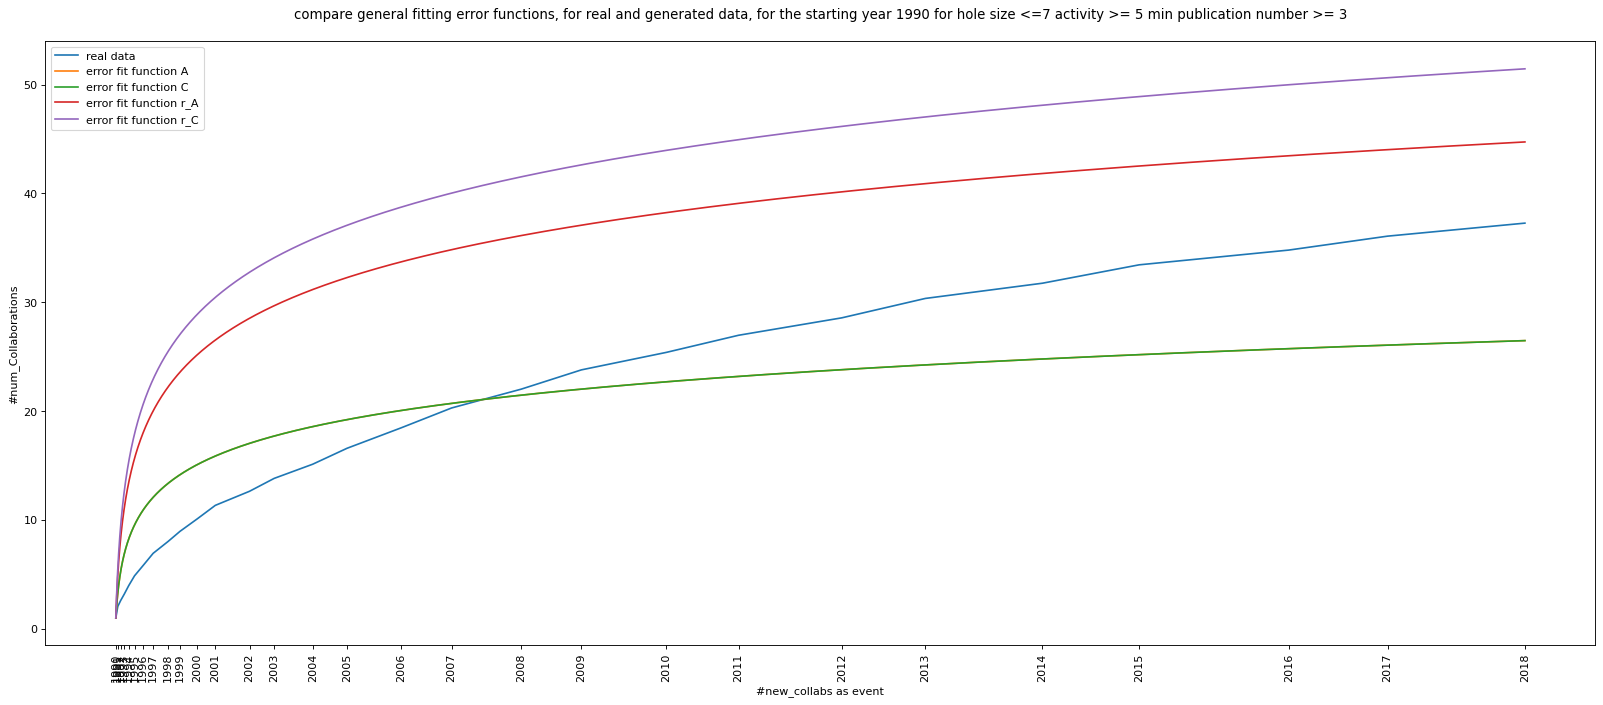

In [35]:
plot_all("1990")

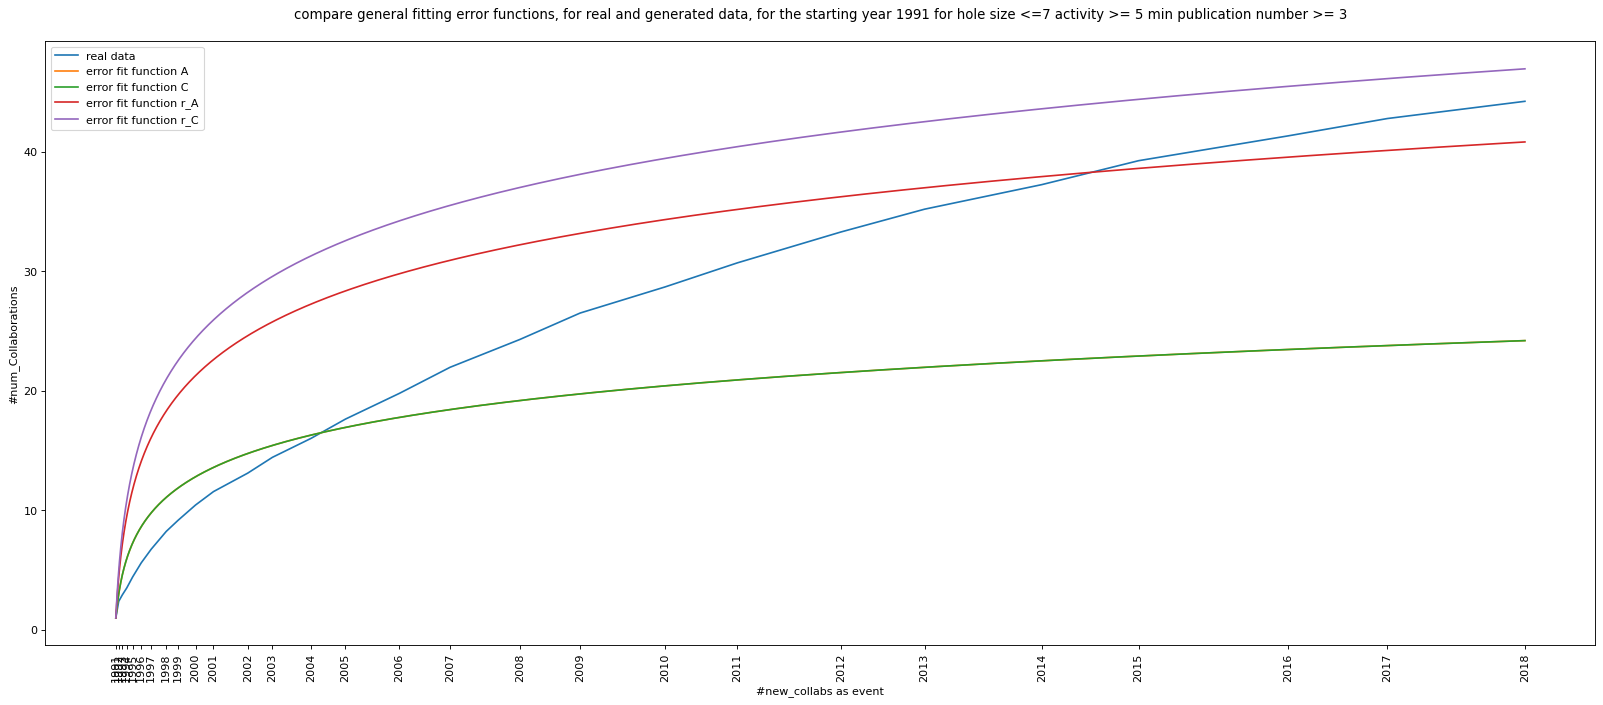

In [36]:
plot_all("1991")

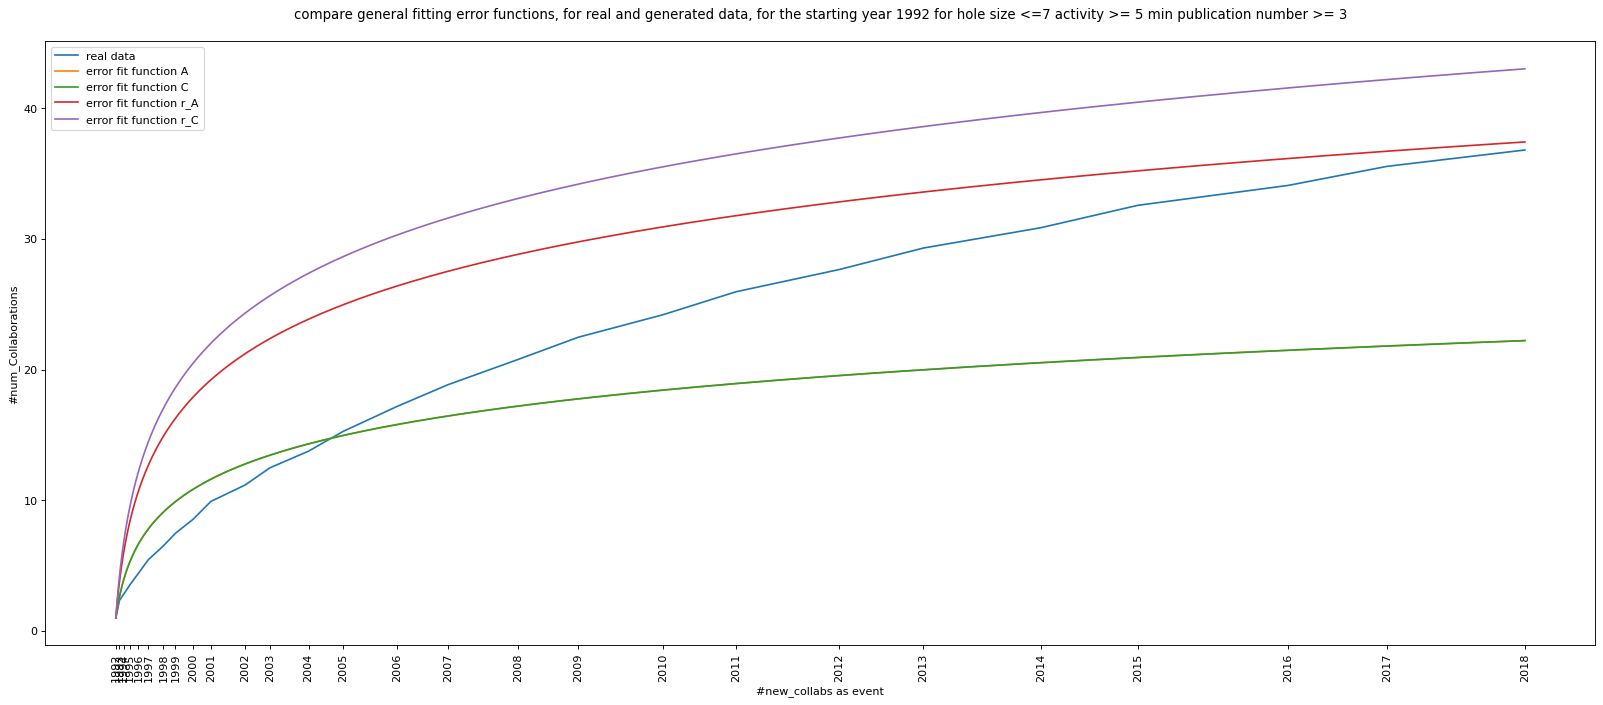

In [37]:
plot_all("1992")

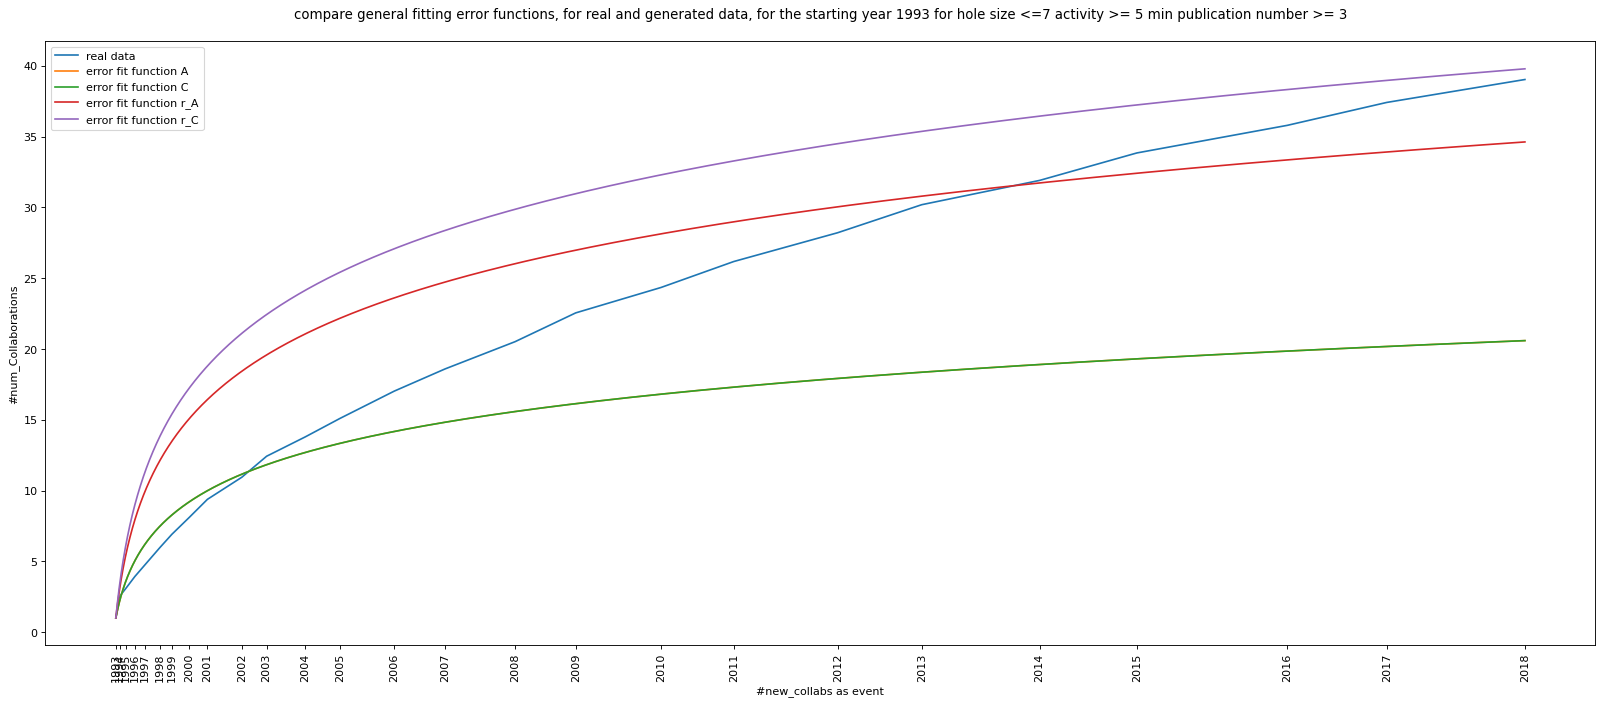

In [38]:
plot_all("1993")

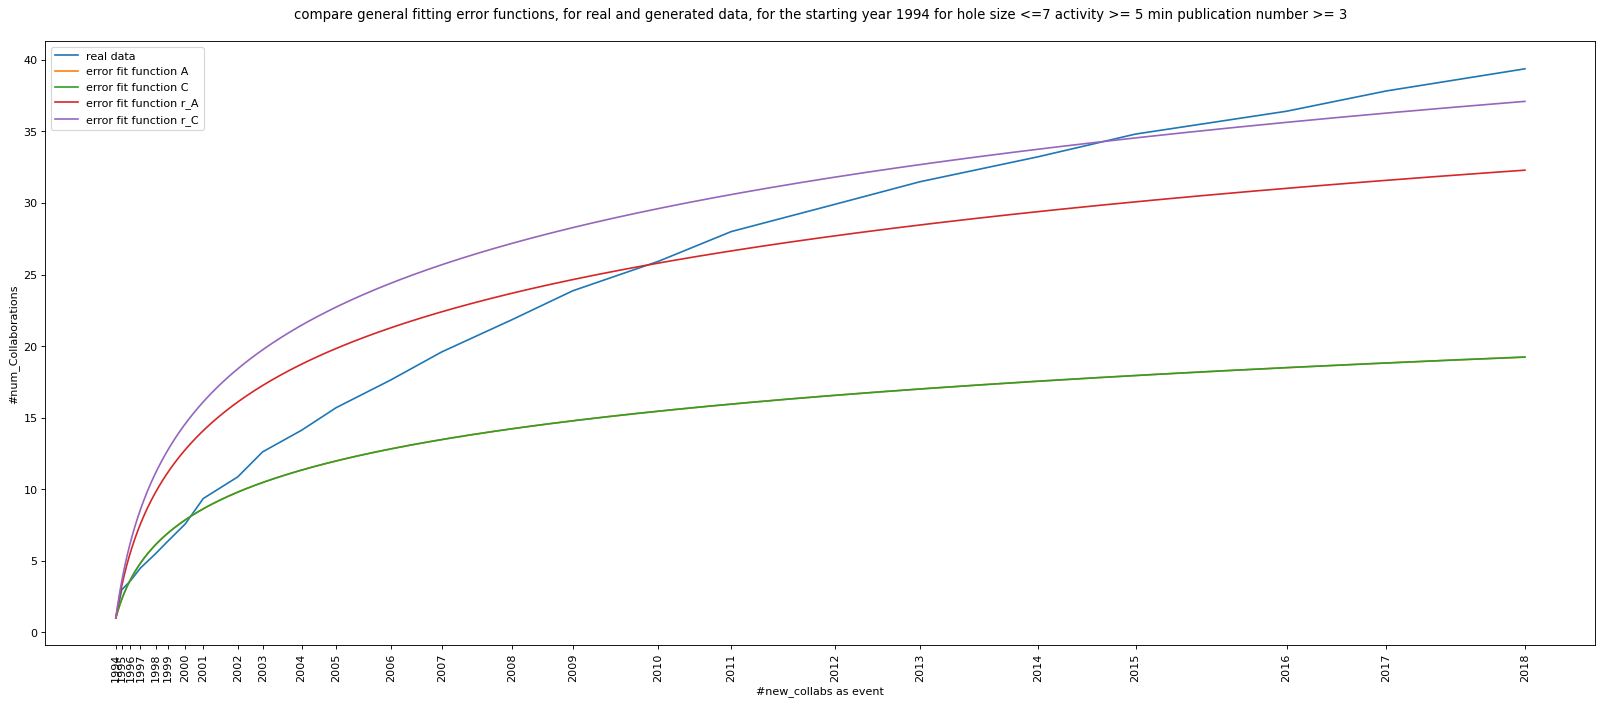

In [39]:
plot_all("1994")

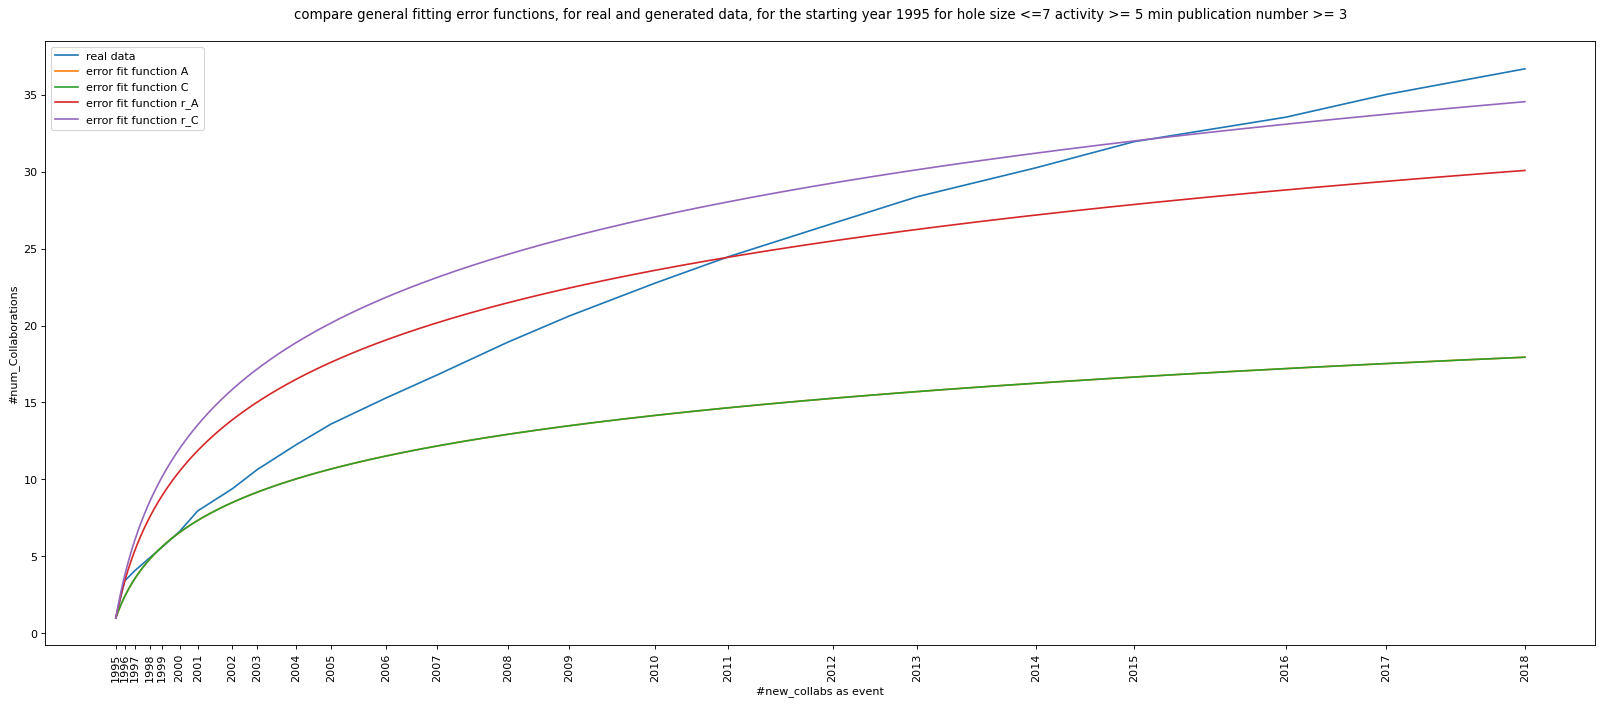

In [40]:
plot_all("1995")

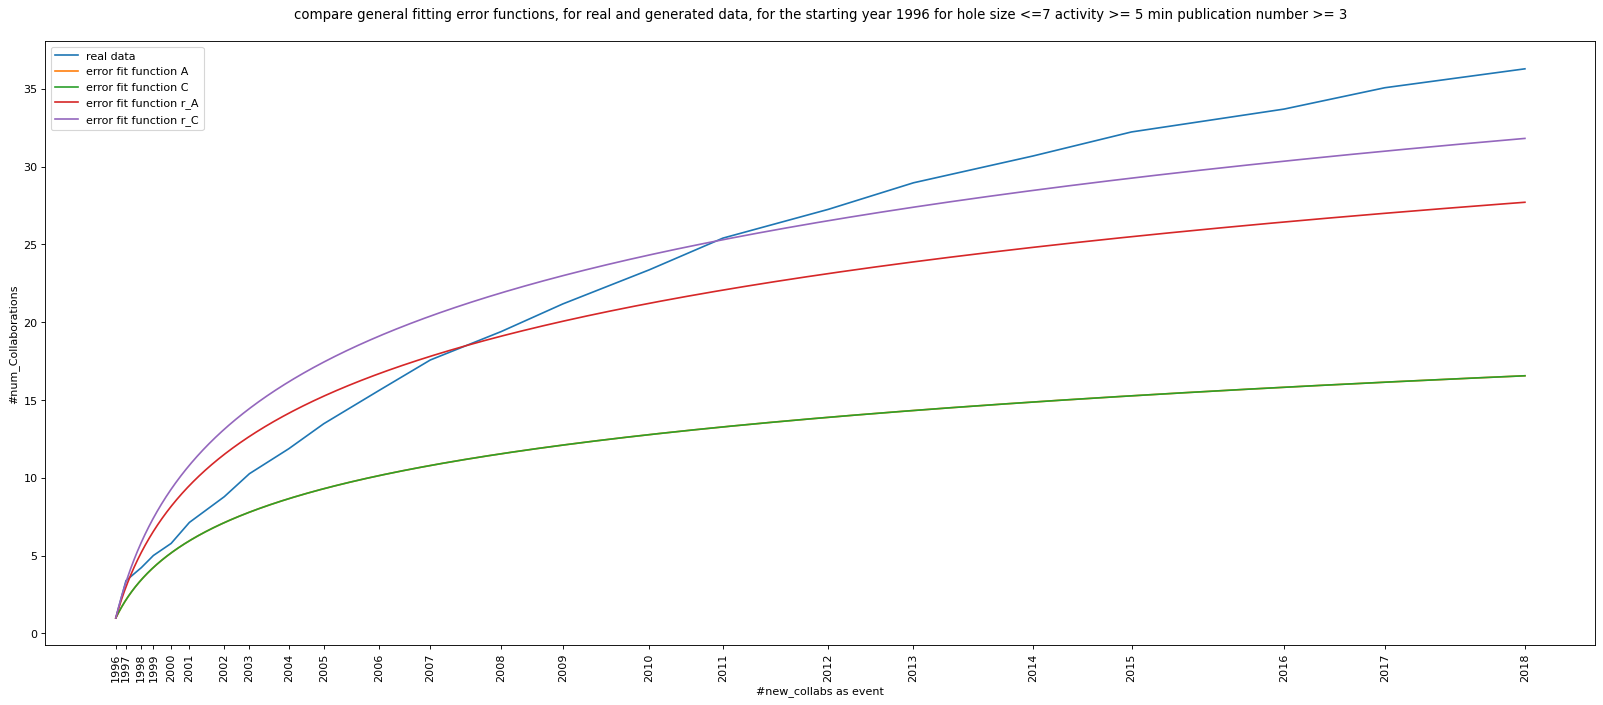

In [41]:
plot_all("1996")

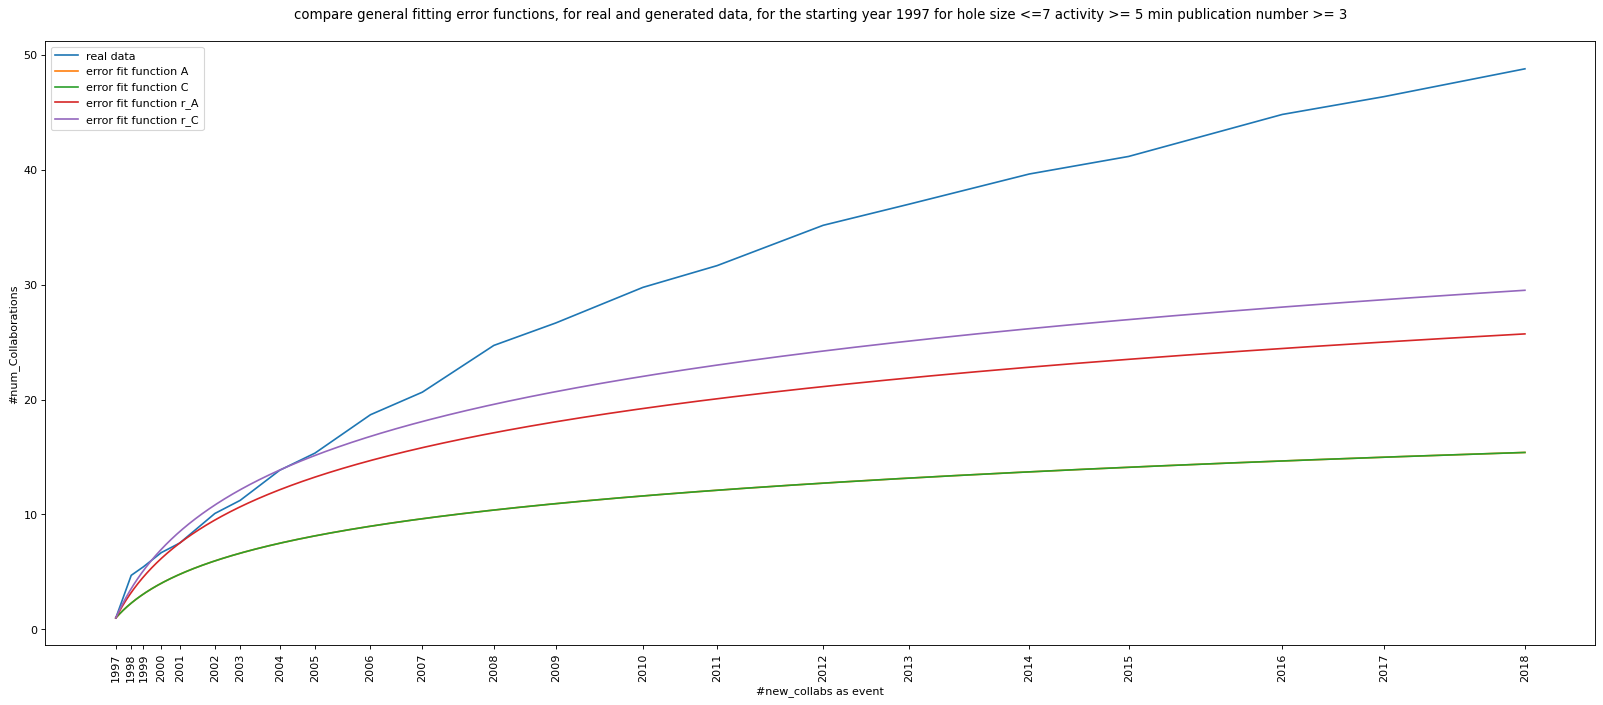

In [42]:
plot_all("1997")

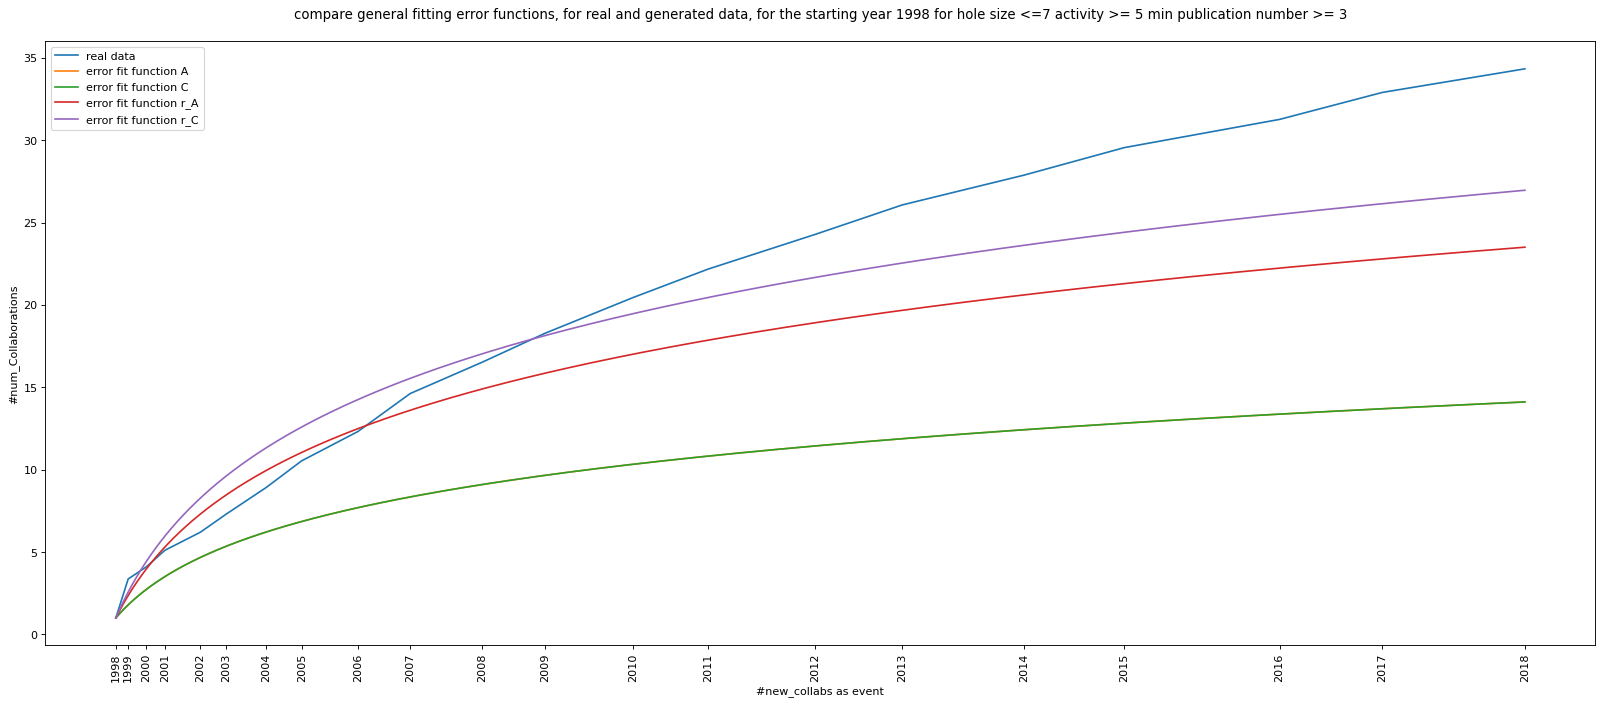

In [43]:
plot_all("1998")

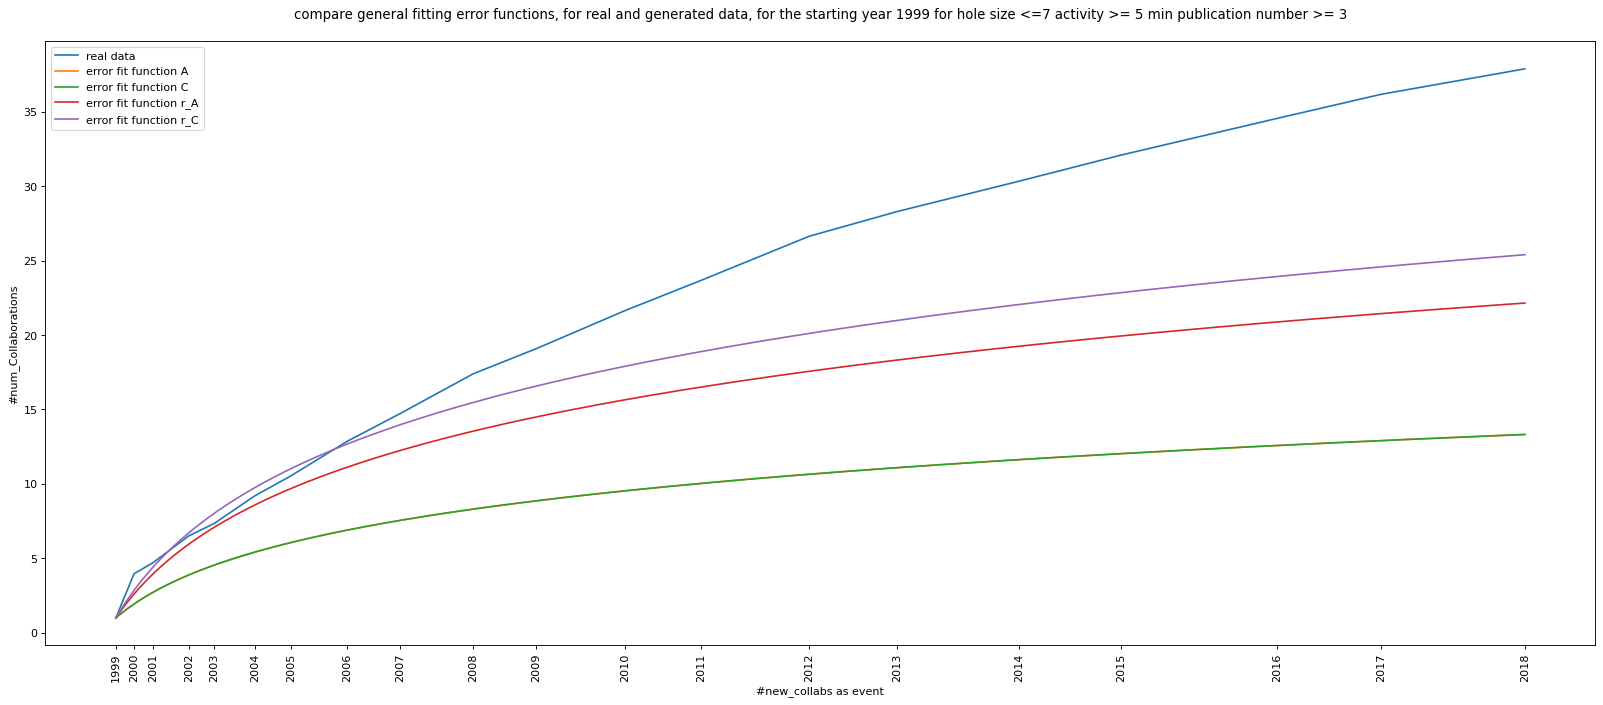

In [44]:
plot_all("1999")

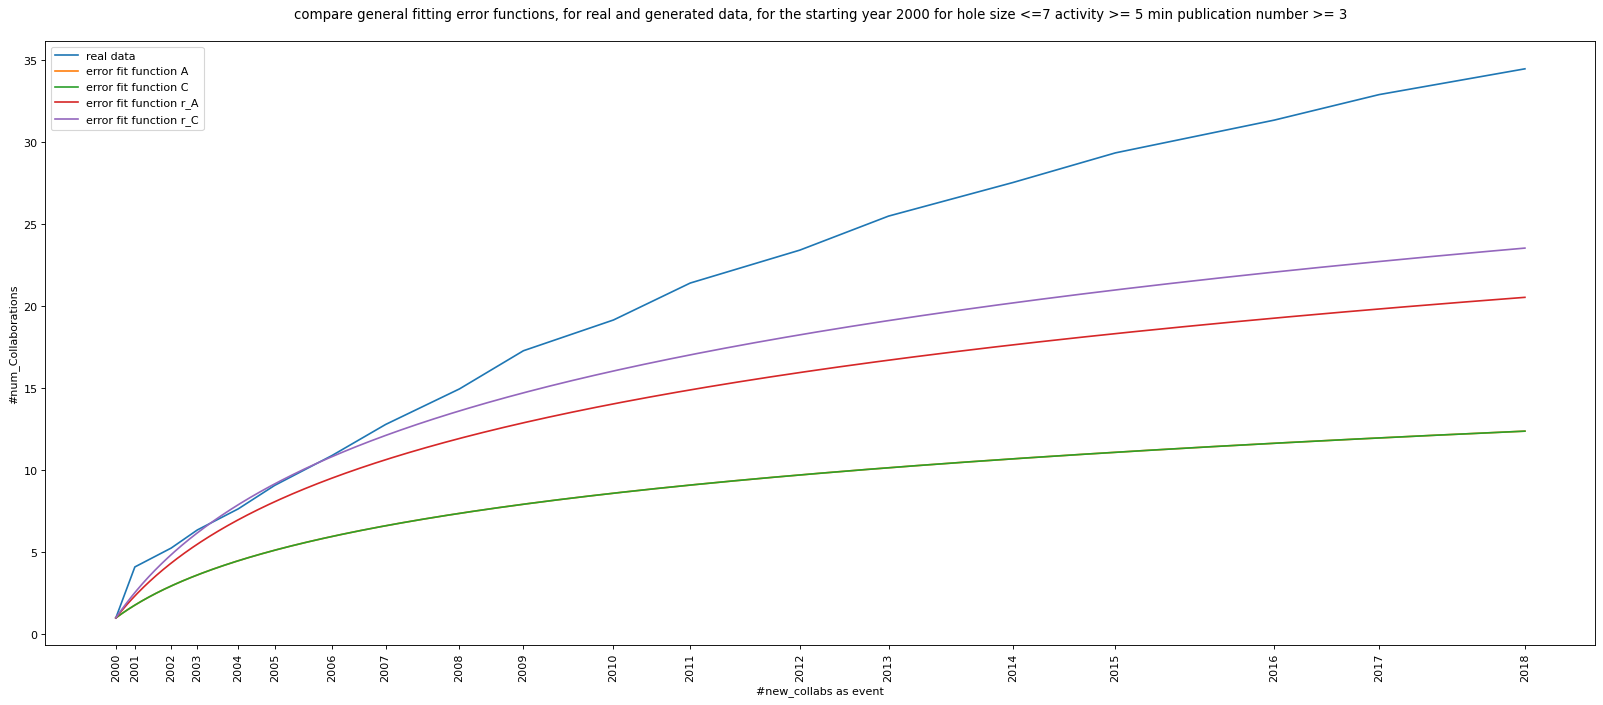

In [45]:
plot_all("2000")

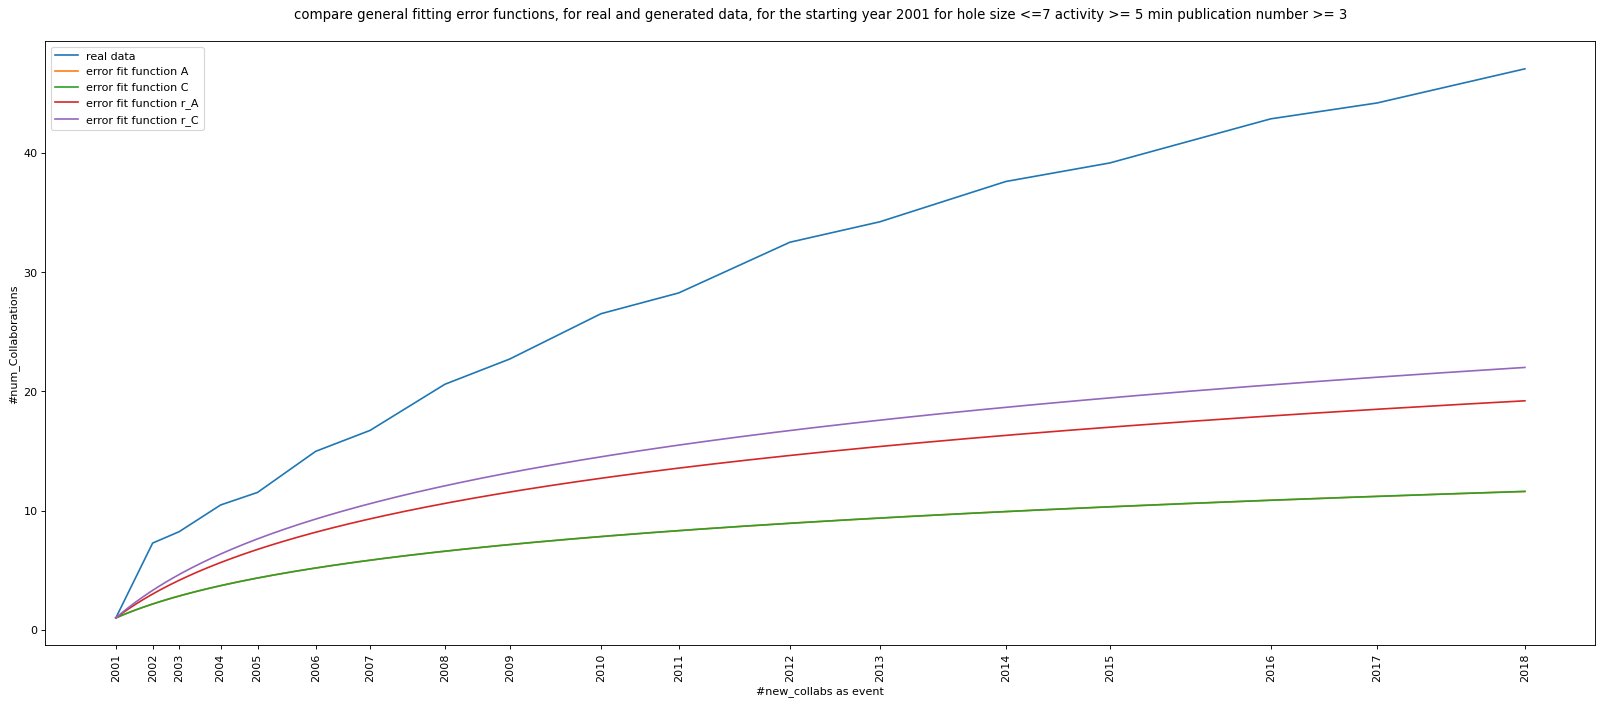

In [46]:
plot_all("2001")

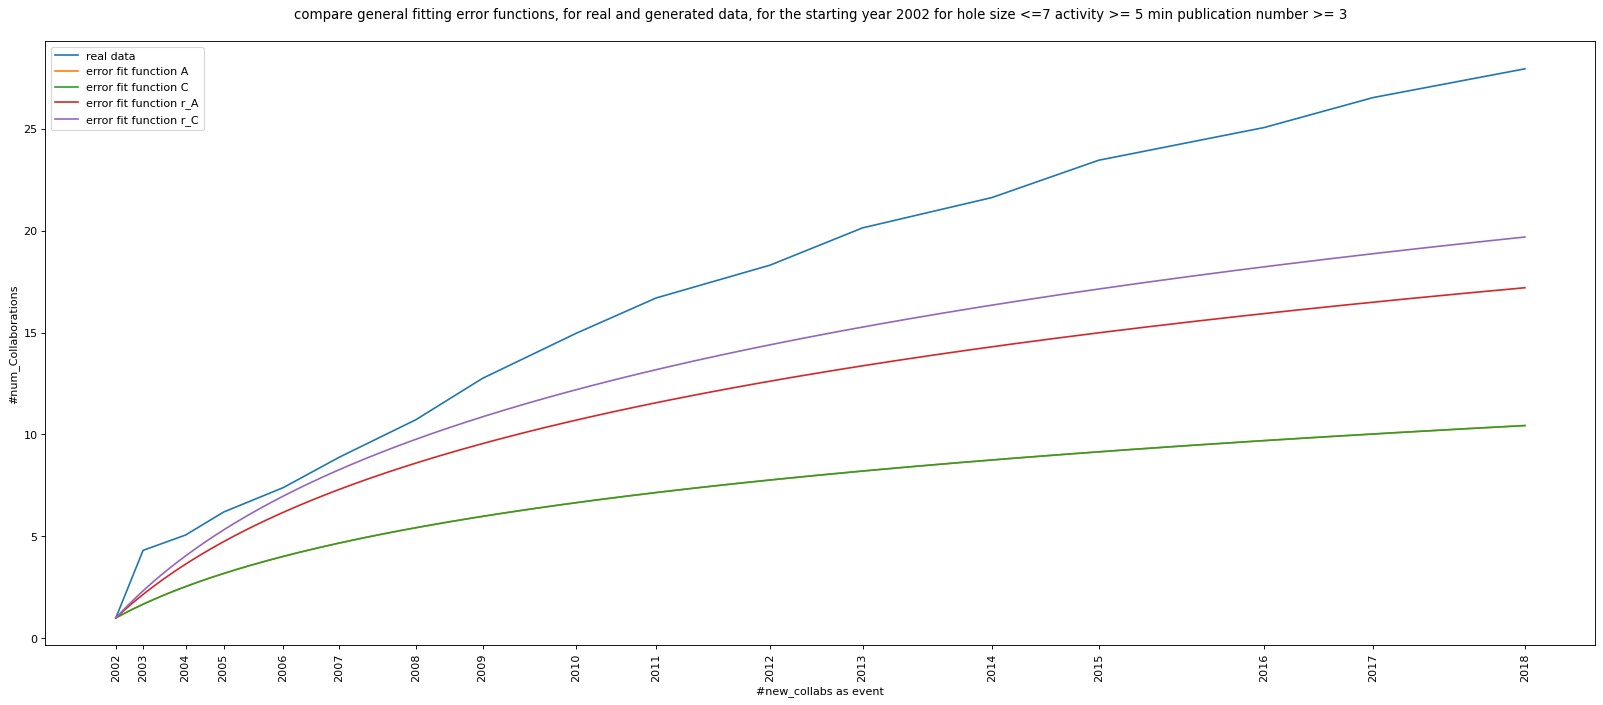

In [47]:
plot_all("2002")

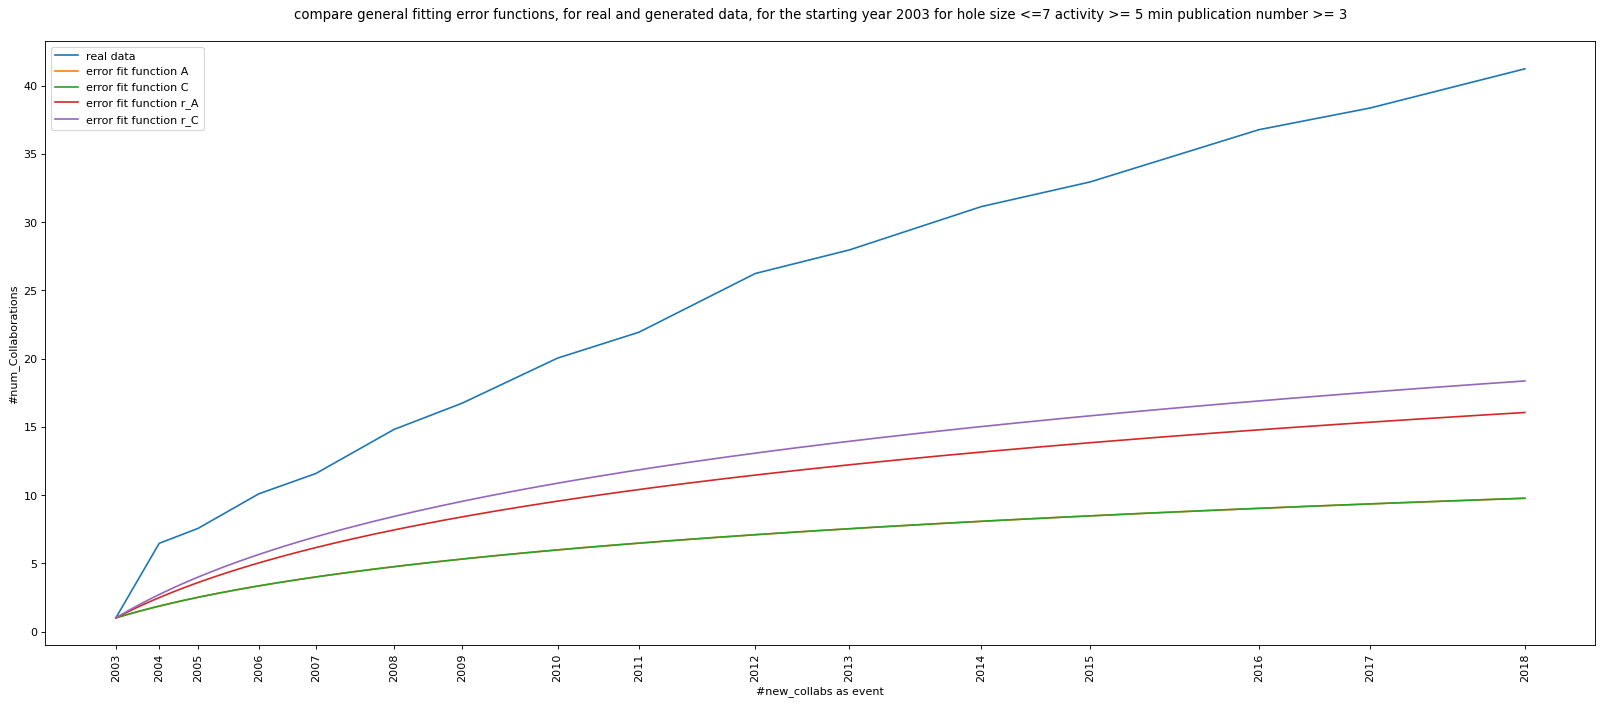

In [48]:
plot_all("2003")

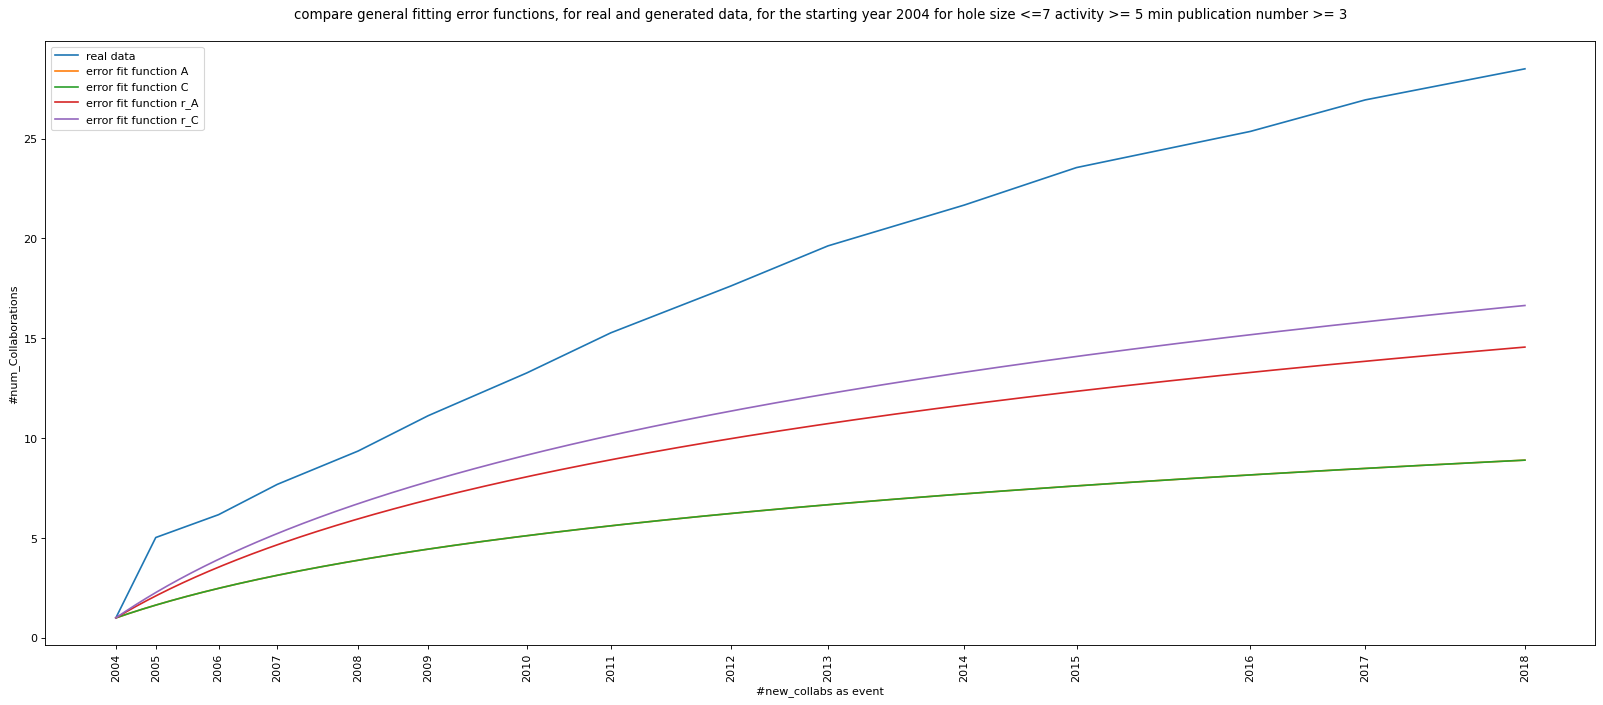

In [49]:
plot_all("2004")

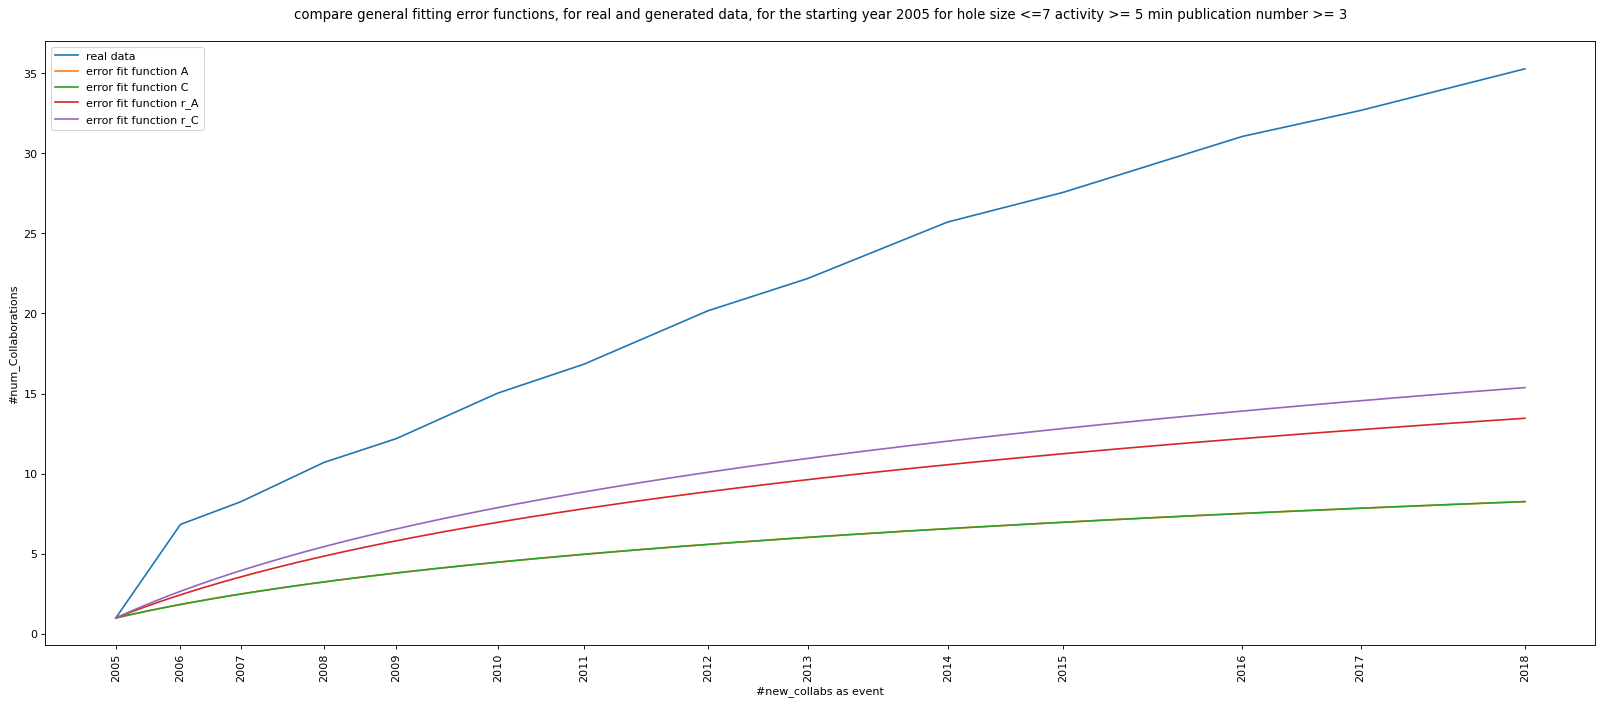

In [50]:
plot_all("2005")

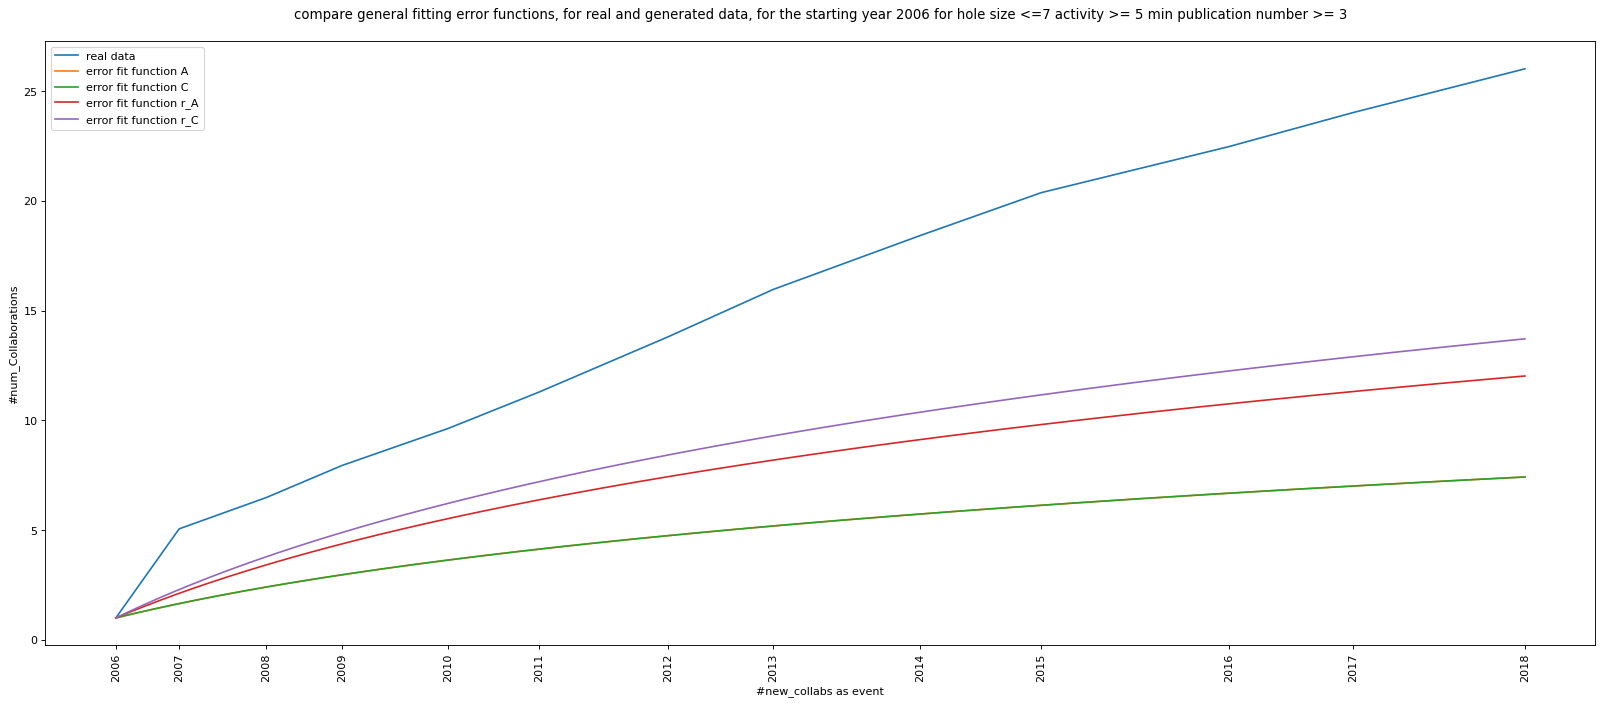

In [51]:
plot_all("2006")

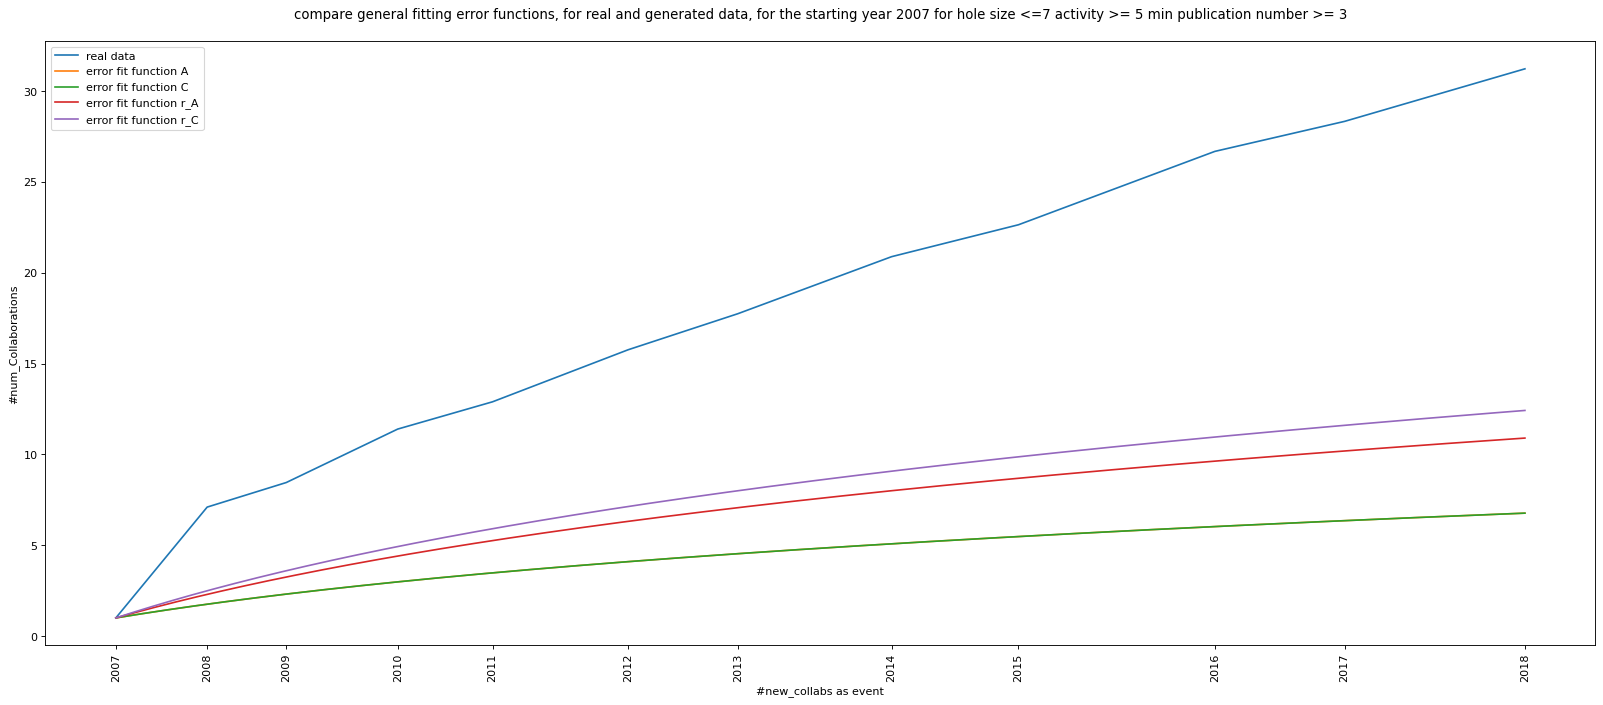

In [52]:
plot_all("2007")

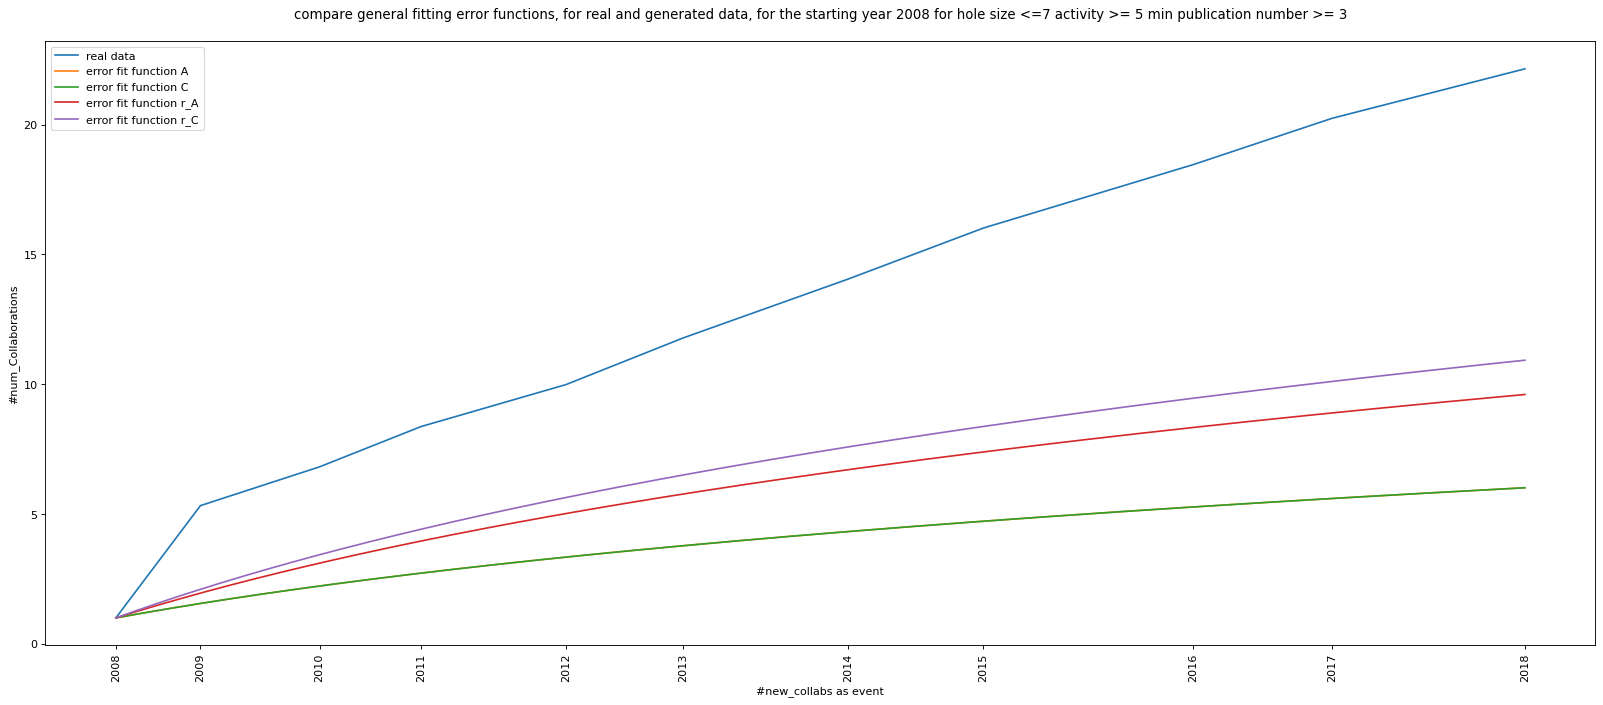

In [53]:
plot_all("2008")

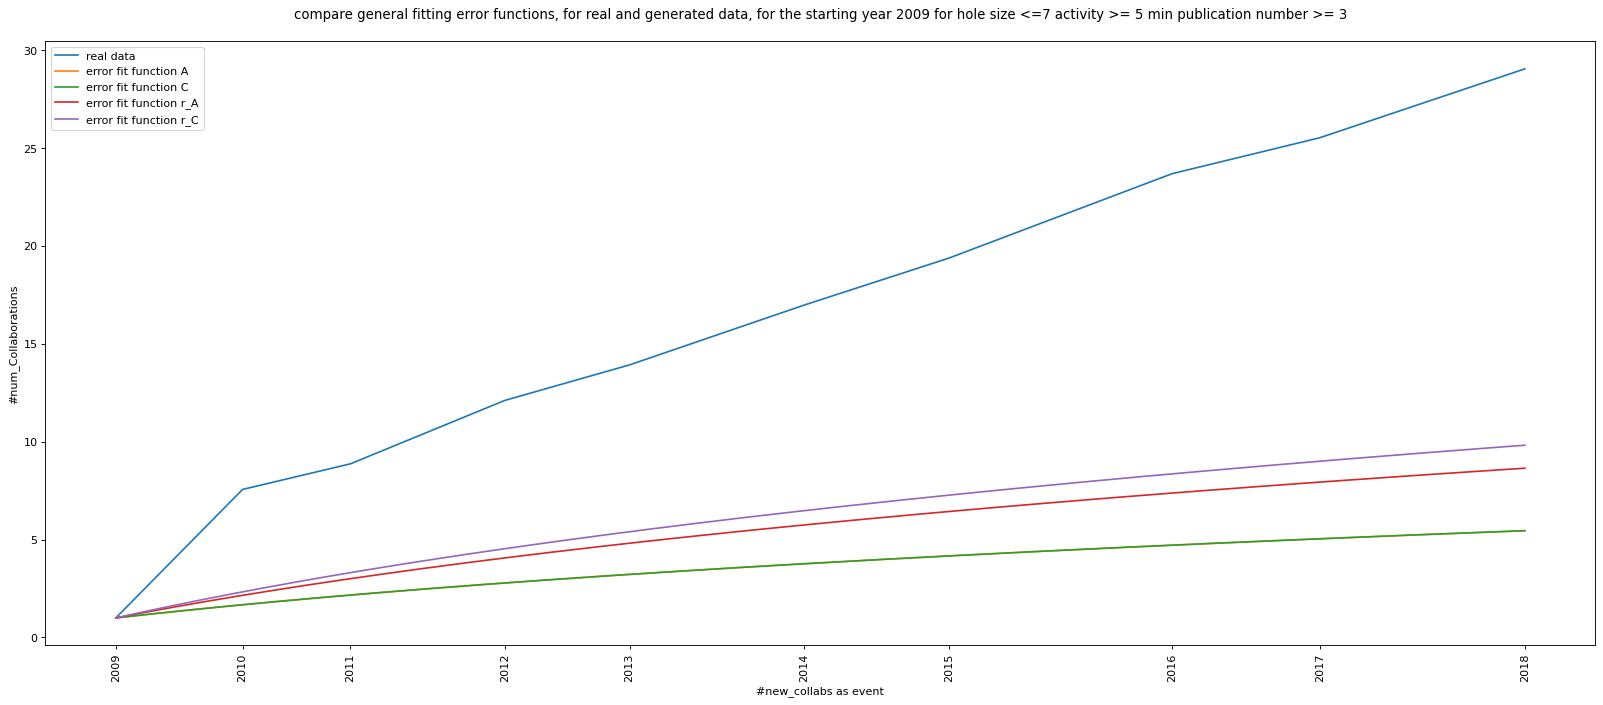

In [54]:
plot_all("2009")

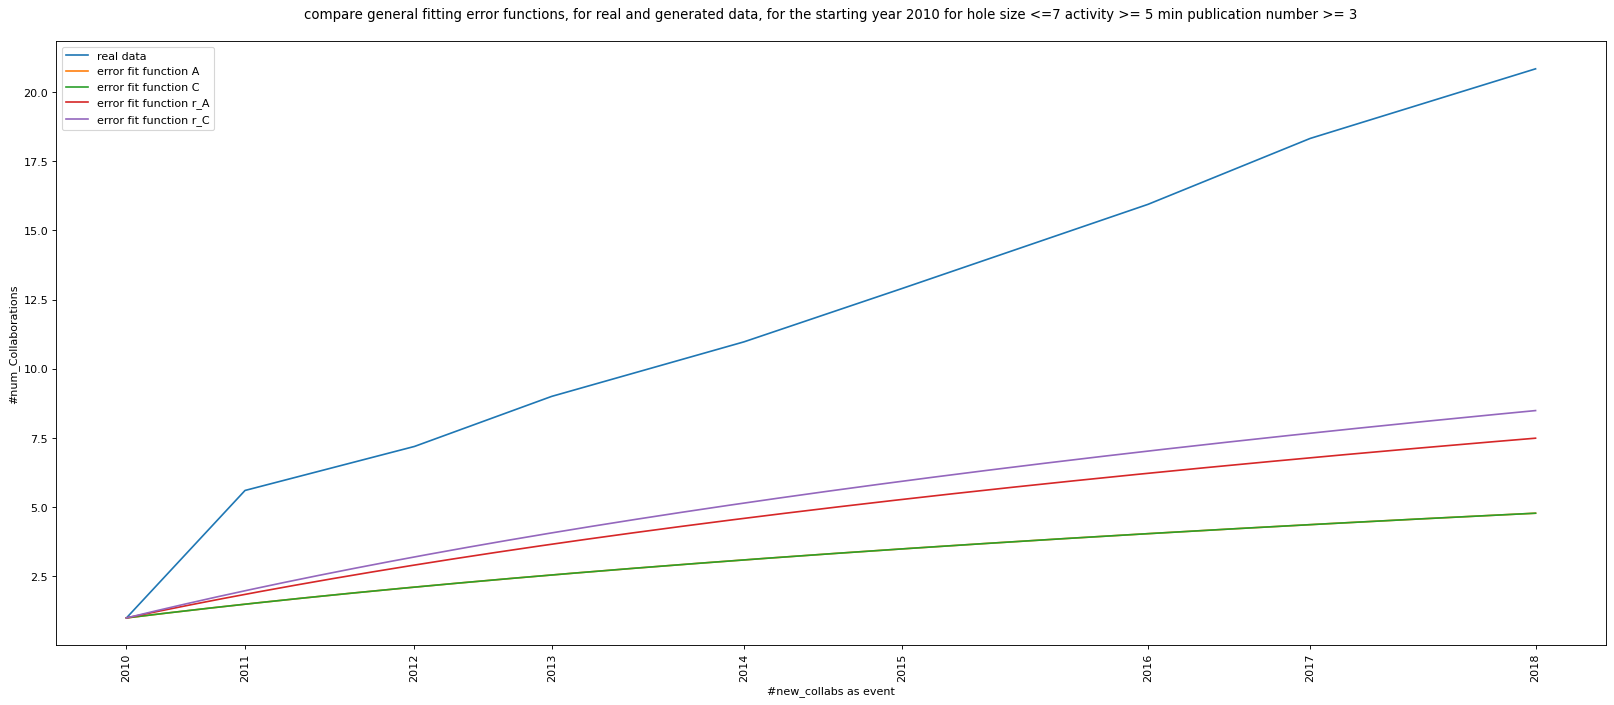

In [55]:
plot_all("2010")

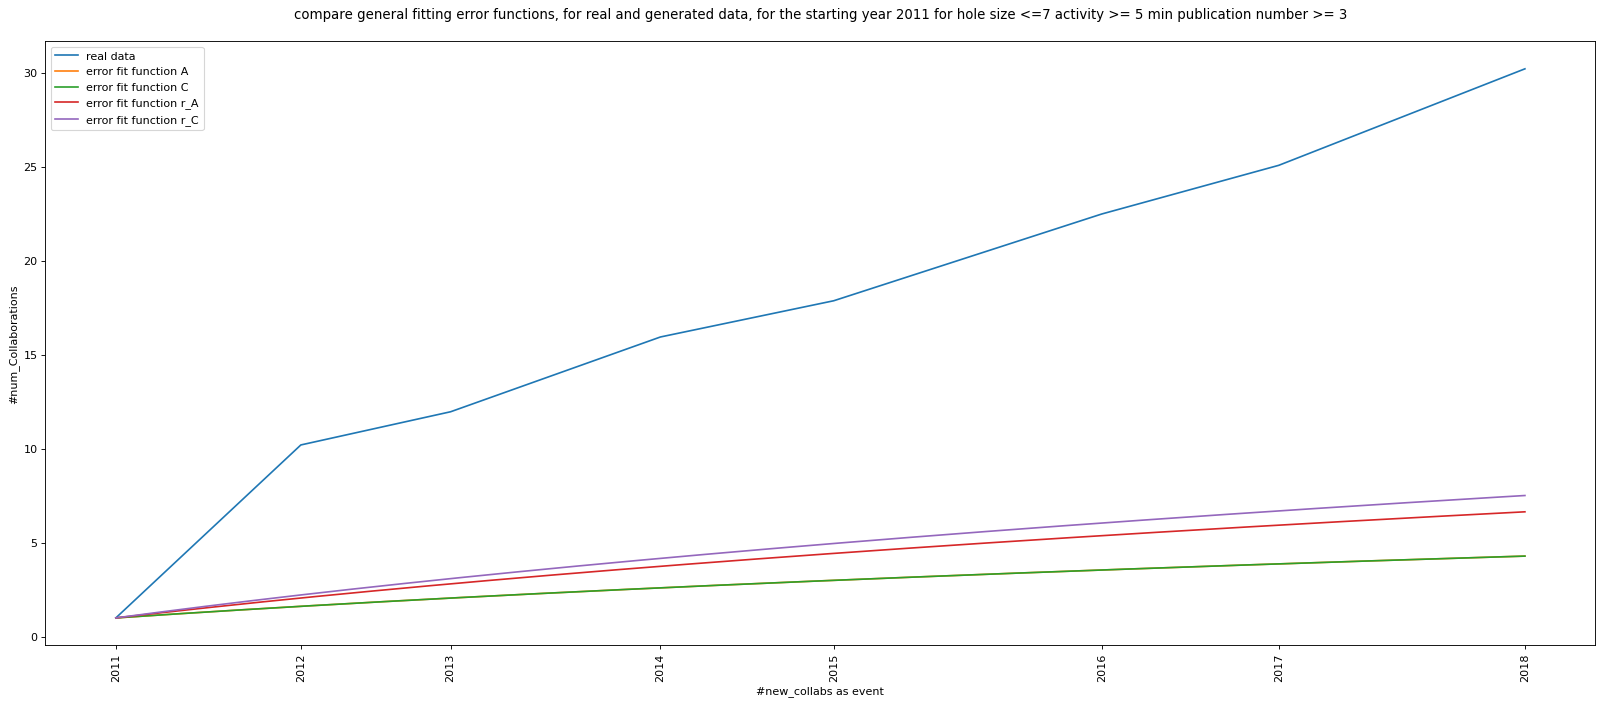

In [56]:
plot_all("2011")

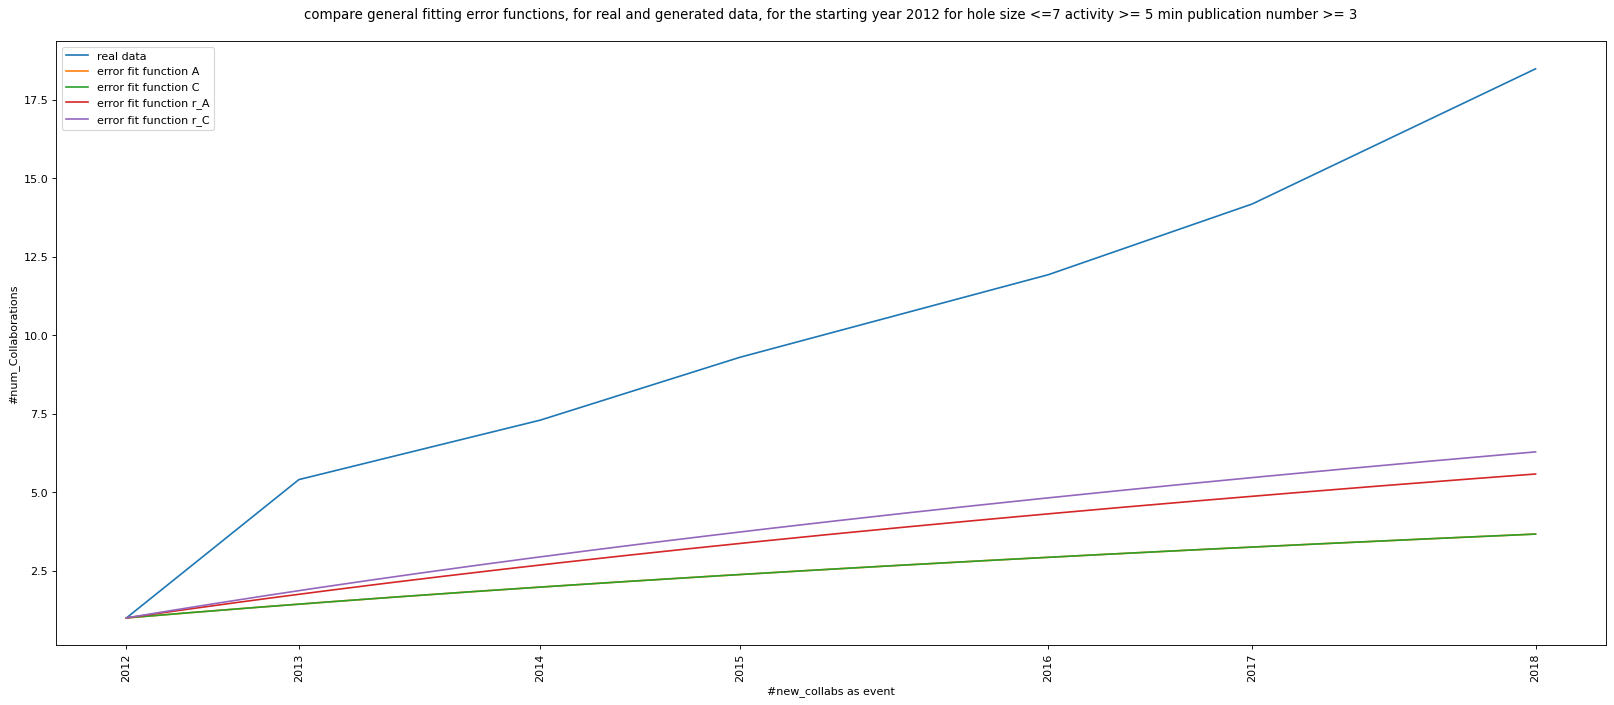

In [57]:
plot_all("2012")

## Compare DD

## REAL

In [9]:
def expDD(k, a, d):
    return d*pow(a,k)

'''def f(i):
    return 4*(P/2*pow((1-P/2), i-1))'''

from scipy.optimize import curve_fit

def fit_expDD(xdata, ydata):

    popt, pcov = curve_fit(expDD, xdata, ydata, maxfev=50000)
    a = popt[0]
    d = popt[1]

    return expDD(xdata, a, d), a, d 

exp DD error: 0.0006383076218503043
with params:
a: 0.82 -> 0.33
d: 0.26 -> 0.75

broken DD error: 0.0003257547383872578
with params:
 xc     8.000000
c1     0.485818
c2     3.217003
a1     1.029941
a2     1.939017
err    0.000326
Name: 5, dtype: float64


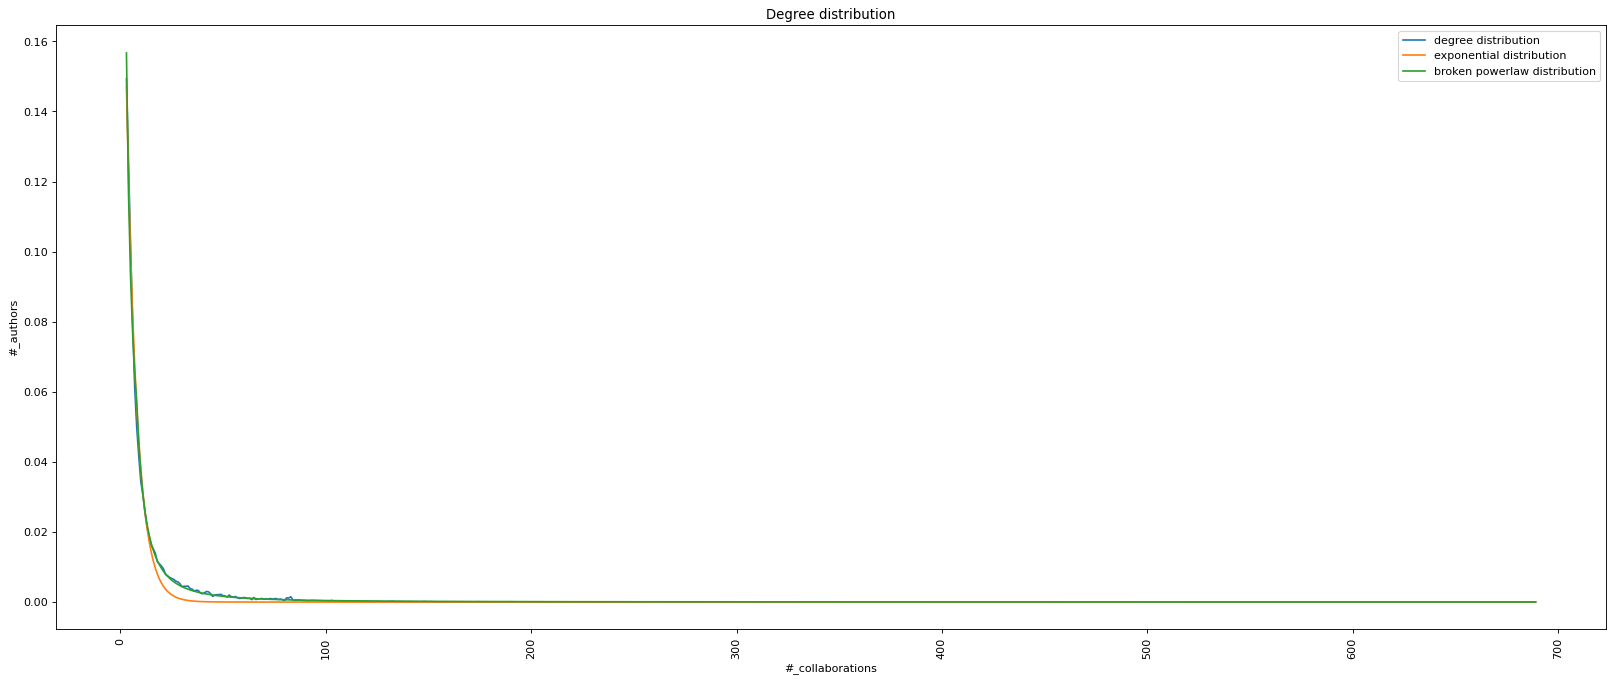

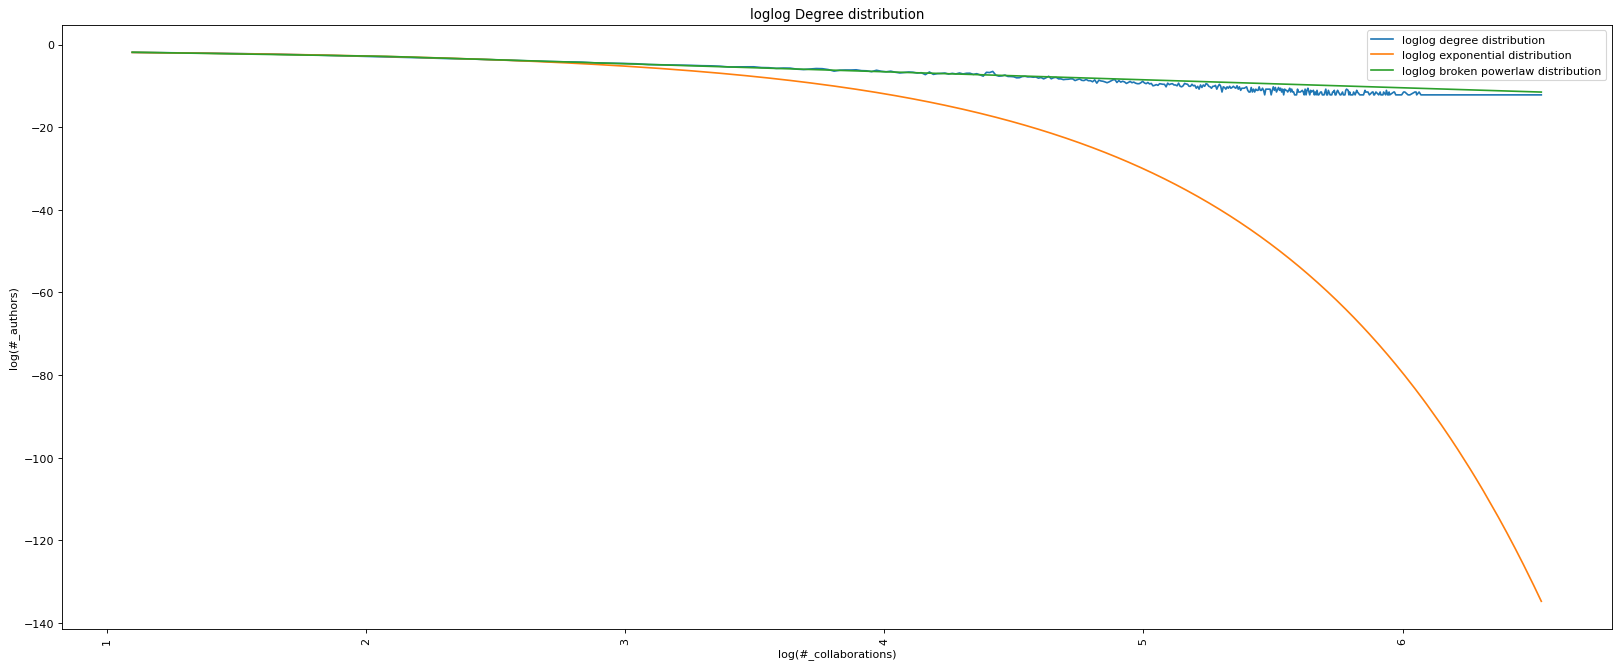

In [10]:
# real data
# DD
colls = get_all_collabs()["2018"].values

unique, counts = np.unique(colls, return_counts=True)
x, y = unique[3:], counts[3:]  
y = [a / sum(y) for a in y] # normalization

# fit exponential DD
exp_y, a, d = fit_expDD(x,y)
err = sum([pow(abs(exp_y[i] - y[i]),2) for i in range(len(x))])
print("exp DD error:", err)
print("with params:")
print("a:", "{:.2f}".format(a), "->", "{:.2f}".format(1/3))
print("d:", "{:.2f}".format(d), "->", "{:.2f}".format(3/4))
print()

#fit broken DD
brokenPL_dd, params = bestBrokenPowelaw(x,y) # fit broken powerlaw on the given DD
err = sum([pow(abs(brokenPL_dd[i] - y[i]),2) for i in range(len(x))])
print("broken DD error:", err) 
print("with params:\n", params)


draw("Degree distribution", 
     "#_collaborations", "#_authors", 
     x, [y, exp_y, brokenPL_dd], 
     ["degree distribution", "exponential distribution", "broken powerlaw distribution"], 25, 10)

draw("loglog Degree distribution",  
     "log(#_collaborations)", "log(#_authors)", 
     np.log(x), [np.log(y), np.log(exp_y), np.log(brokenPL_dd)], 
     ["loglog degree distribution", "loglog exponential distribution", "loglog broken powerlaw distribution"], 25, 10)


# GENERATED

 fixed exp DD error: 0.004204771846792902

exp DD error: 0.001096319205612803
with params:
a: 0.68 -> 0.33
d: 0.43 -> 0.75

broken DD error: 0.0008449305623867628
with params:
 xc     6.000000
c1     0.313485
c2     6.621544
a1     0.898515
a2     2.600937
err    0.000845
Name: 5, dtype: float64


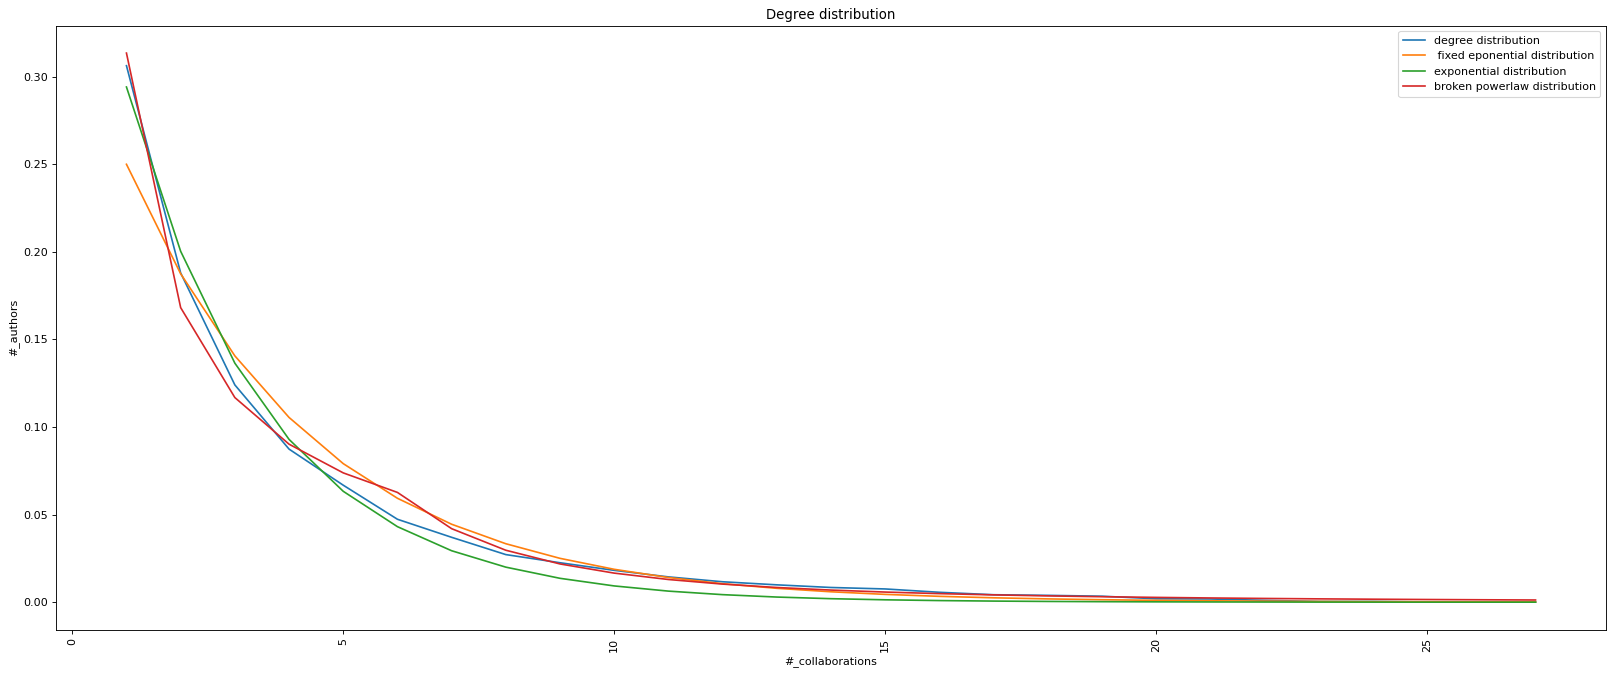

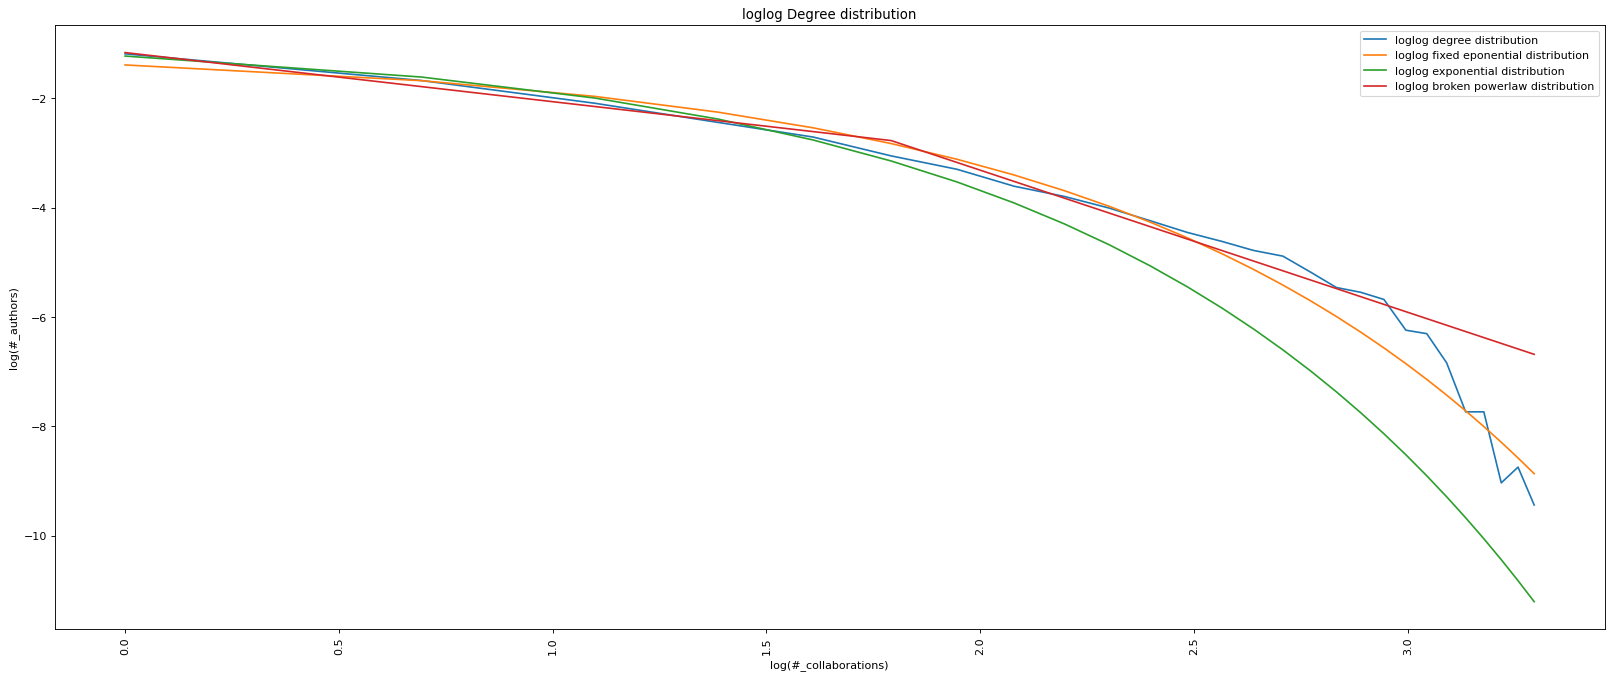

'\nasd = [1/3*pow(3/4, k-1) for k in x]   \n  \ndraw("Degree distribution", \n     "#_collaborations", "#_authors", \n     x, [y, asd],\n     ["degree distribution", ""], 25, 10)\n\ndraw("loglog Degree distribution",  \n     "log(#_collaborations)", "log(#_authors)", \n     np.log(x), [np.log(y), np.log(asd)], \n     ["loglog degree distribution", ""] , 25, 10)'

In [106]:
# gen data
colls = df[str(NUM_EVENTS-1)].values
unique, counts = np.unique(colls, return_counts=True)
x, y = unique, counts  
y = [a / sum(y) for a in y] # normalization


# apply exp DD
fixed_exp_y = [expDD(k, 3/4, 1/3) for k in x] # exponential DD
err = sum([pow(abs(fixed_exp_y[i] - y[i]),2) for i in range(len(x))])
print(" fixed exp DD error:", err)
print()

# fit exponential DD
exp_y, a, d = fit_expDD(x,y)
err = sum([pow(abs(exp_y[i] - y[i]),2) for i in range(len(x))])
print("exp DD error:", err)
print("with params:")
print("a:", "{:.2f}".format(a), "->", "{:.2f}".format(1/3))
print("d:", "{:.2f}".format(d), "->", "{:.2f}".format(3/4))
print()

#fit broken DD
brokenPL_dd, params = bestBrokenPowelaw(x,y) # fit broken powerlaw on the given DD
err = sum([pow(abs(brokenPL_dd[i] - y[i]),2) for i in range(len(x))])
print("broken DD error:", err) 
print("with params:\n", params)

draw("Degree distribution", 
     "#_collaborations", "#_authors", 
     x, [y, fixed_exp_y, exp_y, brokenPL_dd], 
     ["degree distribution", " fixed eponential distribution", "exponential distribution", "broken powerlaw distribution"], 25, 10)

draw("loglog Degree distribution",  
     "log(#_collaborations)", "log(#_authors)", 
     np.log(x), [np.log(y), np.log(fixed_exp_y), np.log(exp_y), np.log(brokenPL_dd)], 
     ["loglog degree distribution", "loglog fixed eponential distribution", "loglog exponential distribution", "loglog broken powerlaw distribution"], 25, 10)
